In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
!pip install nltk

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from dateutil import parser
import missingno as msno
import re
from scipy.stats import mode
import spacy
import tqdm
import pickle
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
import networkx as nx
import nltk
from nltk import TreebankWordTokenizer,WordPunctTokenizer
from nltk.tokenize import word_tokenize,PunktSentenceTokenizer

In [5]:
spacy.__version__

'3.2.2'

In [2]:
pd.set_option("display.max_column",500)
pd.set_option("display.max_rows",500)
sns.set(style="darkgrid")
sns.set_context("talk")

In [ ]:
#load data
data=pd.read_csv(r"E:\Python\Msc-AI-Projects\loan.csv",low_memory=False)

In [ ]:
#Function to create meta data of the data
def create_Meta(data):
    meta_data={'dtypes':data.dtypes,
              'missing_values':round(data.isna().sum()*100/data.shape[0],3),
              'count':[data[i].count() for i in data.columns.values],
              'Number_Uniques':[data[i].nunique() for i in data.columns.values]}
    return pd.DataFrame(meta_data)

In [ ]:
Meta_Data=create_Meta(data)

In [ ]:
#Display meta data of our data
Meta_Data.to_clipboard()

In [ ]:
#Sorting Meta Data on the basis of missing value percentage in descending order
Meta_Data=Meta_Data.sort_values(by='missing_values',ascending=False)

In [ ]:
#Slicing Meta Data on basis of missing value percentage which shall be greater than 30%
Meta_Data[Meta_Data['missing_values']>30]

#### What we need to identify ?


- Does a borrower defaults if funded amount is greater than the average funding amount

- Does a borrower defaults if interest rates are higher than average interest rate

- Do borrowers defaults who have high installments.

- Do emp_length of a borrower affect borrower to default?

- Do type of home ownership have any affect on borrower to default.

- Do high dti determines if a borrower will default or not ?

### Missing Value Treatment

In [ ]:
#We have noticed that there are many columns which have more than 90 percent missing values
# There are columns which have 30% and 64% missing values also . 
#We will drop columns having missing values more than 50% and for rest we will explore and then take a call
missing_value_columns=Meta_Data[Meta_Data['missing_values']>50].index

In [ ]:
#Dropped missing value columns
ft_data=data.drop(missing_value_columns,axis=1)

In [ ]:
#Shape after and before dropping missing value columns
#We notice that 50% approx columns have been dropped
ft_data.shape,data.shape

In [ ]:
ft_data.head()

In [ ]:
def find_pattern(x):
    r=r"[0-9]"
    start,end=re.search(r,x).span()
    x=x[start:end+1]
    return x

In [ ]:
indx=ft_data[ft_data["emp_length"].notnull()]['emp_length'].index.values.tolist()
ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].map(find_pattern)

In [ ]:
#data cleaning
def data_split(a,x,y):
    b=a.split(x)[y]
    return b

ft_data['term']=ft_data.term.apply(data_split,args=(" ",1))


In [ ]:
ft_data["int_rate"]=ft_data.int_rate.apply(data_split,args=("%",0))

In [ ]:

# ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].apply(data_split,args=("+",0))
indx=ft_data[ft_data["revol_util"].notnull()]['revol_util'].index.values.tolist()
ft_data['revol_util'].loc[indx,]=ft_data['revol_util'].loc[indx,].apply(data_split,args=("%",0))

In [ ]:
#Checking if missing data is not at Random
#Creating dichotomous column for missing variable,1->missing,0->not missing
ft_data['desc_isMissing']=np.where(ft_data['desc'].isna(),1,0)
ft_data['emp_title_isMissing']=np.where(ft_data['emp_title'].isna(),1,0)
ft_data['emp_length_isMissing']=np.where(ft_data['emp_length'].isna(),1,0)

In [ ]:
ft_data.loan_status.value_counts()

In [ ]:
#We find that 80% of description of loan provided by borrower is missing for those who have fully paid 
ft_data[ft_data.desc_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

In [ ]:
#We find that 80% of job title provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_title_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

In [ ]:
#We find that 70% of job tenure provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_length_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

It has been seen that majority of the missing data are of those who have fully paid, that is those who are likely to fully pay the loan amount. Hence we can say that the missing data is not at random. There is a clear pattern which we can see

In [ ]:
descMissing_data=ft_data[ft_data.desc_isMissing==1]

In [ ]:
descMissing_data.head()

In [ ]:
print(descMissing_data.loan_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['loan_amnt'].mean(),ft_data['loan_amnt'].mean())

In [ ]:
print(descMissing_data.funded_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['funded_amnt'].mean(),ft_data['funded_amnt'].mean())

In [ ]:
descMissing_data.term.value_counts()

In [ ]:
ft_data[ft_data.desc_isMissing==0]['term'].value_counts()

We see that distribution of term on the basis of description missing and not missing are similar that is loan applicants prefference for 3 years is twice more than of 5 years

In [ ]:
ft_data.int_rate=ft_data.int_rate.astype('float64')
descMissing_data.int_rate=descMissing_data.int_rate.astype('float64')
print(descMissing_data.int_rate.mean(),ft_data[ft_data.desc_isMissing==0].int_rate.mean(),ft_data.int_rate.mean())

In [ ]:
ft_data.emp_length=ft_data.emp_length.astype('float64')
descMissing_data.emp_length=descMissing_data.emp_length.astype('float64')
print(descMissing_data.emp_length.mean(),ft_data[ft_data.desc_isMissing==0].emp_length.mean(),ft_data.emp_length.mean())

In [ ]:
ft_data.revol_util=ft_data.revol_util.astype('float64')
descMissing_data.revol_util=descMissing_data.revol_util.astype('float64')
print(descMissing_data.revol_util.mean(),ft_data[ft_data.desc_isMissing==0].revol_util.mean(),ft_data.revol_util.mean())

No clear pattern in interest rate, revol util and employee length seen for missing description and non missing data 

In [ ]:
#Try Finding Employee Length based on Title and imputing the missings
title_wise_empLen=ft_data.groupby('emp_title',as_index=False,dropna=True)['emp_length'].median()

In [ ]:
emp_title_NA_Length=ft_data[(~ft_data.emp_title.isna())&(ft_data.emp_length.isna())]['emp_title'].values.tolist()

In [ ]:
a=pd.DataFrame()
for i in emp_title_NA_Length:
    a=pd.concat([a,title_wise_empLen[title_wise_empLen.emp_title==i]],axis=0)

In [ ]:
emp_title=a[~a.emp_length.isna()].emp_title.tolist()

In [ ]:
indexes=[]
for i in emp_title:
    ind=ft_data[(ft_data.emp_title==i)&(ft_data.emp_length.isna())]['emp_length'].index.values[0]
    indexes.append(ind)

In [ ]:
indexes

In [ ]:
missing_emp_length_data=ft_data.loc[indexes,:]
emp_lnt=a[~a.emp_length.isna()].emp_length.tolist()    
missing_emp_length_data.loc[:,'emp_length']=emp_lnt


In [ ]:
ft_data=pd.concat([ft_data.drop(indexes,axis=0),missing_emp_length_data],axis=0)

In [ ]:
ft_data.reset_index(drop=True,inplace=True)

In [ ]:
indexes=ft_data[(ft_data.emp_length.isna())].index.values.tolist()

In [ ]:
#Dropping rows where emp_length is NA
ft_data.drop(indexes,axis=0,inplace=True)

In [ ]:
ft_data.isna().sum()*100/ft_data.shape[0]

In [ ]:
#Grouping employee title most frequent based on employee experience
#Treating Missing Values of Employee title
empTitle_by_Length=ft_data.groupby("emp_length",as_index=False).agg({"emp_title":mode})
for i in range(len(empTitle_by_Length)):
    empTitle_by_Length.emp_title[i]=empTitle_by_Length.emp_title[i].mode[0]

In [ ]:
empTitle_by_Length

In [ ]:
indexes=ft_data[ft_data.emp_title.isna()].index.values.tolist()
empTitle_NAdata=ft_data.loc[indexes,:]
empTitle_NAdata[(empTitle_NAdata.emp_length==1.0)&(empTitle_NAdata.emp_title.isna())]["emp_title"].replace(np.nan,"Bank of America",inplace=True)

In [ ]:
empTitle_NAdata.emp_length.value_counts().sum()

In [ ]:
#Imputation of missing values in employee title based on employee length
a=pd.DataFrame()
for i in empTitle_NAdata.emp_length.unique().tolist():
    dummy=empTitle_NAdata[(empTitle_NAdata.emp_length==i)&(empTitle_NAdata.emp_title.isna())]
    dummy.emp_title.replace(np.nan,empTitle_by_Length[empTitle_by_Length.emp_length==i].emp_title.values[0],inplace=True)
    a=pd.concat([dummy,a],axis=0)
    
ft_data=pd.concat([ft_data.drop(indexes,axis=0),a],axis=0)

In [ ]:
ft_data.isna().sum()*100/ft_data.shape[0]

In [ ]:
#Identifying patterns and treating null values in pub_rec_bankcruptcies
ft_data['pub_rec_bankruptcies'].value_counts(dropna=False)

In [ ]:
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_status':np.count_nonzero})

In [ ]:
#We notice the 697 missing public record of bankcruptcies are not the ones which are either charged off or who have fully paid..
#They belong to Current loan applicants
#Either this NaN can be another category itself or they belong to one specific category
ft_data[ft_data['pub_rec_bankruptcies'].isna()].groupby("loan_status",dropna=False)["pub_rec_bankruptcies"].count()

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount
#We see that those who have frequently shown bankcruptcies are the ones who have applied for high loan amounts. 
#The missing 697 are the ones which have applied for least loan amount
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_amnt':'mean'})

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average funded amount
#There is difference in loan applied amount and funded amount
#We see that those who do not have bankcruptcies or who have maximum record of bankcruptcies that is 2 have the highest amount funded. 
#The missing 697 are the ones which have got lesser funded amount
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'funded_amnt':'mean'})

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are the ones who have applied for the least amount and those who are current have the highest loan amount.
#For NAN category those whose loan is being charged off has the highest loan amount 
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'mean'})

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are in majority numbers and the current applicants are the least
#Of NaNs i.e 697 applicants 83% are already paid off and only 17% have been charged of
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'count'})

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average interest rate
#We see that as the number of bankruptcies increases, it increases when the average interest rate rises. 
#The missing 697 have the least interest rate @11% approximately
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'int_rate':'mean'})

In [ ]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and installment amount
#We see for all the number of bankcruptcies, people who have public record of bankcruptcies as two, pays highest isntallment
#For NAN category the installment is lesser comparatively
ft_data.groupby(['pub_rec_bankruptcies'],dropna=False).agg({'installment':'mean'})

In [ ]:
#We see for zero and NaN category of the public record of bankcruptcies, majority of the applicants have home ownership as Rent and then Mortgage
#Those who displays bankcruptcies have higher frequencies of martgage as home ownership
ft_data.groupby(["pub_rec_bankruptcies","home_ownership"],dropna=False).agg({"emp_title":"count"})

In [ ]:
#Since the patterns seen above we see lot of similarities in NaN category and bankcruotcies class 0 , which is suggestive of that applicants who are having public_bankcrupticies as NaN have zero bankcruptcies
#Hence We can impute NaNs with 0
ft_data.pub_rec_bankruptcies.fillna(0.0,inplace=True)

In [ ]:
ft_data.isna().sum()*100/ft_data.shape[0]

In [ ]:
#Identifying pattern and trating revol_util - Though revolving line utilization rate is the relationship between balances and the credit limit
revol_util_na_df=ft_data[ft_data.revol_util.isna()]
revol_util_df=ft_data[~ft_data.revol_util.isna()]

In [ ]:
#We can see that revol_util is NaN because revol_bal is 0, hence we should replace the NaN values of revol_util with 0 
revol_util_na_df.loc[:,['revol_util','revol_bal']]

In [ ]:
#Replacing NaN values
ft_data.revol_util.fillna(0.0,inplace=True)

In [ ]:
#Finding % of missing values
ft_data.isna().sum()*100/ft_data.shape[0]

In [ ]:
#Finding value counts of application_type
ft_data.application_type.value_counts()

In [ ]:
#Removing columns since they have only single unique value 
#It does not give any information
cols=["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens","pymnt_plan","application_type","acc_now_delinq","initial_list_status","delinq_amnt",
"policy_code"]
ft_data.drop(cols,axis=1,inplace=True)


In [ ]:
#Finding % of missing values
ft_data.isna().sum()*100/ft_data.shape[0]

In [ ]:
#Subsetting title and desc column where title is missing 
empty_title_df=ft_data[(ft_data.title.isna())].loc[:,['desc','title']]

In [ ]:
#Loading Spacy en_core_web_md model
nlp=spacy.load("en_core_web_md")

In [ ]:
#Creating function to strip down html tags
def strip_html_tags(text):
    soup = BeautifulSoup(str(text), "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [ ]:
#Removing html tags from description column
empty_title_df['desc']=empty_title_df['desc'].map(strip_html_tags)

In [ ]:
#creating Function to extract topic from description column
def topic_extraction(text):
    span=[]
    nlp=spacy.load("en_core_web_md")
    doc=nlp(str(text))
    pattern=[[{"DEP":"compound","OP":"+"},{"DEP":"nsubj","OP":"?"},{"DEP":"amod","OP":"?"}],[{"DEP":"advcl","OP":"+"},{"DEP":"prt","OP":"?"},{"DEP":"det","OP":"?"},{"DEP":"dobj","OP":"?"}]]
#     pattern1=[]
    matcher=Matcher(nlp.vocab,validate=True)
    matcher.add("match_1",pattern)
    matches=matcher(doc)
    span.append([doc[i[1]:i[2]] for i in tqdm.tqdm(matches)])
    return span
    
    
    

    

In [ ]:
#Extracting topics
empty_title_df['Topics']=empty_title_df.desc.map(topic_extraction)

In [ ]:
#Imputing title , topics generated using description column
ft_data.title.loc[25181]="travel"
ft_data.title.loc[27468]="debt"
ft_data.title.loc[28460]="education"
ft_data.title.loc[28976]="credit card"
ft_data.title.loc[31564]="credit card"

In [ ]:
#Removing the rows where both description and title were NaN
empty_title_rows=ft_data[ft_data.title.isna()].index.tolist()
ft_data.drop(empty_title_rows,axis=0,inplace=True)

In [ ]:
#Finding % Missing Values
ft_data.isna().sum()*100/ft_data.shape[0]

not removing the rows of last_pymnt_d & last_credit_pull_d since its very less % of data and the columns at this point doesnt seems to be potential contributing column

In [ ]:
ft_data.reset_index(drop=True,inplace=True)

### Outlier Detection


In [4]:
#Continuous variable list
num_cols=['loan_amnt','open_acc', 'funded_amnt', 'funded_amnt_inv','int_rate', 'installment','annual_inc','dti','revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt','total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_amnt']

In [5]:
#subsetting numerical values
num_data=ft_data[num_cols]

In [6]:
num_data.describe()

loan_amnt      open_acc   funded_amnt  funded_amnt_inv  \
count  38648.000000  38648.000000  38648.000000     38648.000000   
mean   10482.335270      9.317067  10252.225031      9700.384864   
std     5326.611335      4.395101   5115.469453      5051.119836   
min     3828.912097      2.000000   3823.519980      3315.608151   
25%     5500.000000      6.000000   5500.000000      5000.000000   
50%    10000.000000      9.000000   9950.000000      9000.000000   
75%    15000.000000     12.000000  15000.000000     14425.000000   
max    18754.393637     44.000000  18210.587865     17595.514775   

           int_rate   installment     annual_inc           dti     revol_bal  \
count  38648.000000  38648.000000   38648.000000  38648.000000  38648.000000   
mean      12.050305    304.914489   65204.896108     13.325358  11365.465636   
std        3.712298    147.740552   31228.177642      6.667679   9202.078752   
min        5.420000    117.603382    5352.782969      0.000000      0.000000   
25%        9.320000    168.430000   41354.400000      8.200000   3745.000000   
50%       11.860000    282.760000   60000.000000     13.415000   8937.000000   
75%       14.590000    434.400000   83196.000000     18.590000  17149.250000   
max       22.495000    535.905942  133853.372279     29.990000  29370.943996   

         revol_util     total_acc     out_prncp  out_prncp_inv   total_pymnt  \
count  38648.000000  38648.000000  38648.000000   38648.000000  38648.000000   
mean      48.937988     21.304326     11.428009      11.383146  11178.986933   
std       28.340303      8.201686     68.129011      67.860711   6308.851110   
min        0.000000     10.727564      0.000000       0.000000   3186.140783   
25%       25.500000     14.000000      0.000000       0.000000   5623.622683   
50%       49.500000     20.000000      0.000000       0.000000  10023.245370   
75%       72.500000     29.000000      0.000000       0.000000  16645.148002   
max       99.900000     33.514156    428.191008     426.571709  21299.860025   

       total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
count     38648.000000     38648.000000   38648.000000        38648.000000   
mean      10585.986305      9106.708608    1908.715863            0.446609   
std        6223.617426      5009.573024    1549.080470            1.919889   
min        2682.412543      2787.822077       0.000000            0.000000   
25%        5175.977500      4750.000000     671.640000            0.000000   
50%        9378.350000      8000.000000    1367.380000            0.000000   
75%       15914.040000     13874.190000    2858.092500            0.000000   
max       20606.496870     16940.605483    4897.276966            8.703396   

         recoveries  collection_recovery_fee  last_pymnt_amnt  
count  38648.000000             38648.000000     38648.000000  
mean      41.683061                 3.597673      2021.835109  
std      155.750487                21.529859      2524.570558  
min        0.000000                 0.000000         0.000000  
25%        0.000000                 0.000000       221.997500  
50%        0.000000                 0.000000       554.930000  
75%        0.000000                 0.000000      3337.532500  
max      790.152920               162.267484      7169.335892

In [7]:
#Define Scaler
def MinMaxScaler(df:pd.DataFrame,col):
    Min=df[col].min()
    Max=df[col].max()
    def minmaxscale(x):
        if Min>0:
            z=(x-Min)/(Max-Min)
            return z
        else:
            z=(x-Min)/(Max-Min)
            return z
    return df[col].map(minmaxscale)
        

In [8]:
#Scaling continuous variables in order to bring each column in same unit, i.e unit free
scaled_data=pd.DataFrame()
for i in num_cols:
    scaled_data[i]=MinMaxScaler(num_data,i)

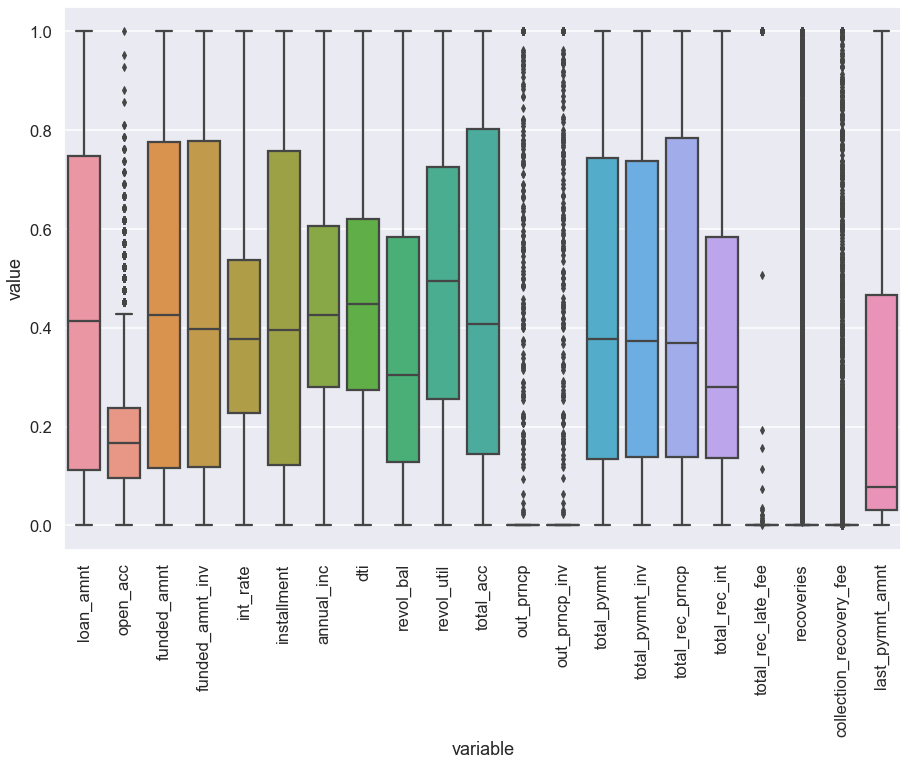

In [10]:
#Box plot to identify outliers
plt.figure(figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(scaled_data))
plt.xticks(rotation=90)
plt.show()

In [11]:
#we see that loan_amount,funded_amnt and inv_funded_amnt have similar trend in outliers and distribution - it is suggestive of interdependency 
# We see that all the above shown variables have outliers
#lets identify the pattern before we classify them as outliers
#Creating Outlier_Detector 


def outlier_treatment(df:pd.DataFrame,col:str):
    def IQR_outlier_detector(df:pd.DataFrame,col:str):
        global upper_bound
        global lower_bound
        third_quartile=df[col].quantile(.75)
        first_quartile=df[col].quantile(.25)
        IQR=third_quartile-first_quartile
        upper_bound=third_quartile + (1.5*IQR)
        lower_bound=first_quartile - (1.5*IQR)
        
        return (upper_bound,lower_bound)
    def stdv_outlier_detector(df:pd.DataFrame,col:str):
        global ub
        global lb
        stdev=df[col].std()
        mean=df[col].mean()
        ub=mean+stdev
        lb=mean-stdev
        return (ub,lb)
    ub,lb=stdv_outlier_detector(df,col)
    perc=df[(df[col]>=lb)&(df[col]<=ub)].shape[0]/df.shape[0]
    if perc>=.68:
        ub,lb= stdv_outlier_detector(df,col)
        return df[col].clip(lower=lb,upper=ub)
    else:
        ub,lb= IQR_outlier_detector(df,col)
        return df[col].clip(lower=lb,upper=ub)
        
        


In [12]:
#Treating Outliers
for i in scaled_data.columns:
    ft_data[i]=outlier_treatment(ft_data,i)

In [13]:
#Treating Outliers
for i in scaled_data.columns:
    scaled_data[i]=outlier_treatment(scaled_data,i)

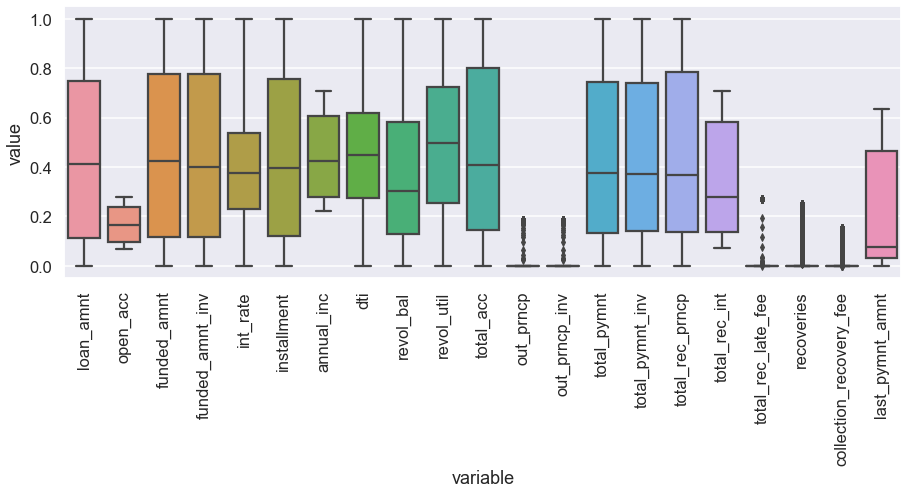

In [14]:
#Data Post outlier treatment
plt.figure(figsize=(15,5))
sns.boxplot(x="variable", y="value", data=pd.melt(scaled_data))
plt.xticks(rotation=90)
plt.show()

### Derived Variables

In [43]:
#Dropping row index where there are null values
index=ft_data[ft_data.last_credit_pull_d.isna()].index.values.tolist()
ft_data.drop(index,axis=0,inplace=True)

In [45]:
#Dropping row index where there are null values
index=ft_data[ft_data.last_pymnt_d.isna()].index.values.tolist()
ft_data.drop(index,axis=0,inplace=True)

In [41]:
#Splitting Function
def split_year(x):
    if x!=np.nan:
        x=x.split("-")[-1]
        x=int(x)
        return x
    return x


In [ ]:
#Split the year
ft_data.issue_d=ft_data.issue_d.map(split_year)

In [48]:
#Creating Derived variables by Split the year
ft_data['last_credit_pull_yr']=ft_data.last_credit_pull_d.map(split_year)
ft_data['last_pymnt_yr']=ft_data.last_pymnt_d.map(split_year)

In [50]:
ft_data['application_to_funded_diff']=ft_data['loan_amnt']-ft_data['funded_amnt']
ft_data['total_inst']=ft_data['term'].astype(float)*ft_data['installment']
ft_data['balance']=ft_data['total_inst']-ft_data['total_pymnt']
ft_data['installment_to_income']=round(ft_data['total_inst']*100/(ft_data['annual_inc']*ft_data['term'].astype(float)/12),2)

ft_data['LC_pull_to_pymnt_Tenure']=ft_data['last_credit_pull_yr']-ft_data['last_pymnt_yr']
ft_data['LC_pull_to_issue_Tenure']=ft_data['last_credit_pull_yr']-ft_data['issue_d']

In [51]:
ft_data['last_pymnt_to_issue_Tenure']=ft_data['last_pymnt_yr']-ft_data['issue_d']

In [ ]:
ft_data['funded_amt_range']=pd.qcut(ft_data['funded_amnt'],q=4).astype('object').astype(str)
ft_data['int_rate_range']=pd.cut(ft_data['int_rate'],5).astype('object').astype(str)
ft_data['annual_inc_range']=pd.cut(ft_data['annual_inc'],5).astype('object').astype(str)

### EDA

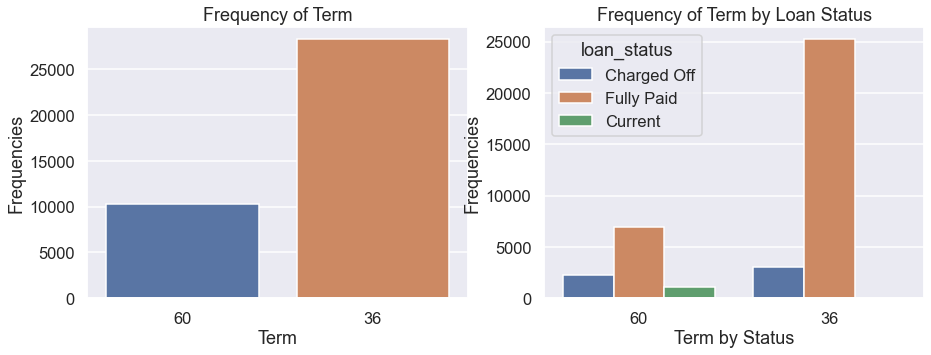

In [52]:
#Term Distribution 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Frequency of Term")
sns.countplot(x='term',data=ft_data)
plt.xlabel("Term")
plt.ylabel("Frequencies")
plt.subplot(1,2,2)
plt.title("Frequency of Term by Loan Status")
sns.countplot(x='term',data=ft_data,hue='loan_status')
plt.xlabel("Term by Status")
plt.ylabel("Frequencies")
plt.show()

- We have seen most borrowers prefer 36 months duration , i.e short duration

- Most charged off borrowers are from 36 months duration.


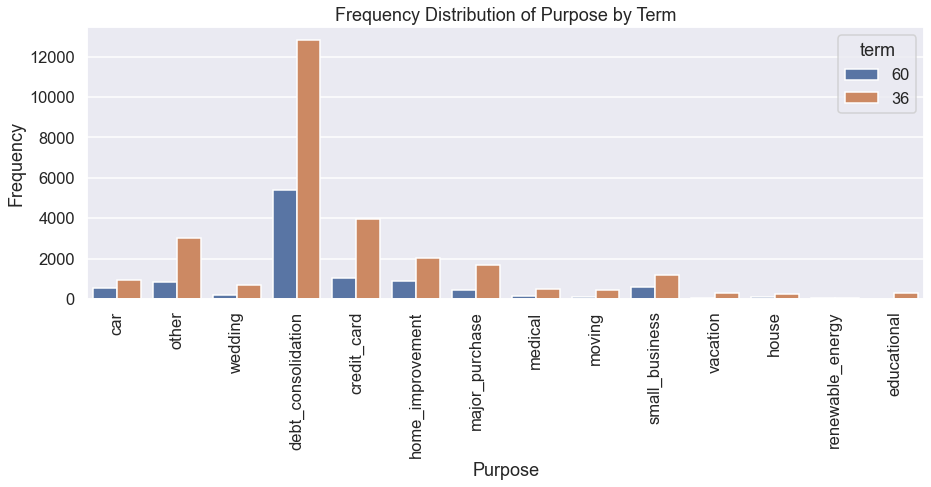

In [55]:
#Term Distribution based on purpose - Majority of borrowers who prefer 60 months duration have purpose of debt consolidation
plt.figure(figsize=(15,5))
plt.title("Frequency Distribution of Purpose by Term")
sns.countplot(x='purpose',data=ft_data,hue='term')
plt.xlabel("Purpose")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

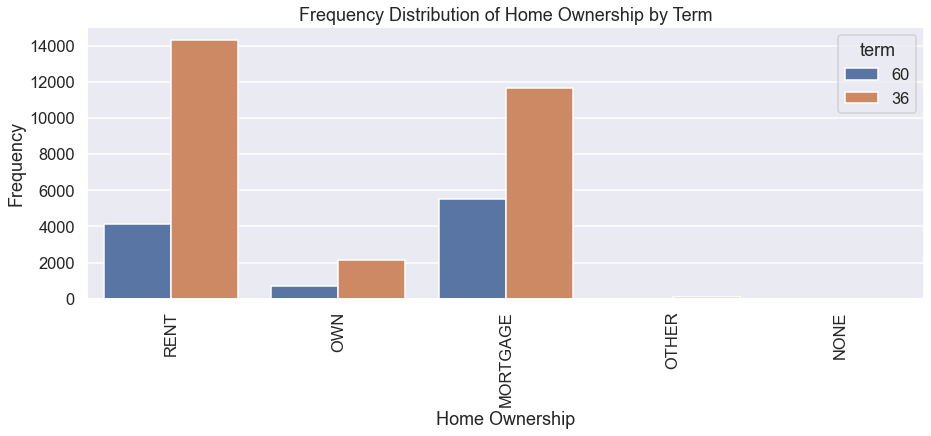

In [57]:
#Term Distribution based on ownership - Majorly for Rent and Mortgage, long duration loan were taken
plt.figure(figsize=(15,5))
plt.title("Frequency Distribution of Home Ownership by Term")
sns.countplot(x='home_ownership',data=ft_data,hue='term')
plt.xlabel("Home Ownership")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

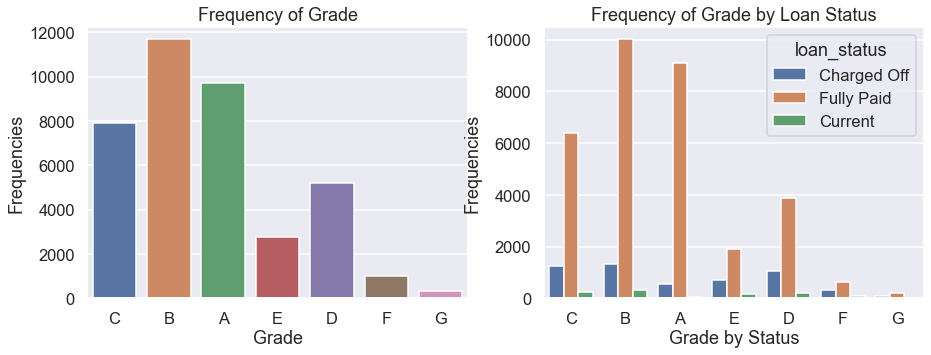

In [58]:
#Grade Distribution - Most of the customers belong to Grade B and A.
#Most of the borrowers who were charged off belongs to grade B,C & D
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Frequency of Grade")
sns.countplot(x='grade',data=ft_data)
plt.xlabel("Grade")
plt.ylabel("Frequencies")
plt.subplot(1,2,2)
plt.title("Frequency of Grade by Loan Status")
sns.countplot(x='grade',data=ft_data,hue='loan_status')
plt.xlabel("Grade by Status")
plt.ylabel("Frequencies")
plt.show()

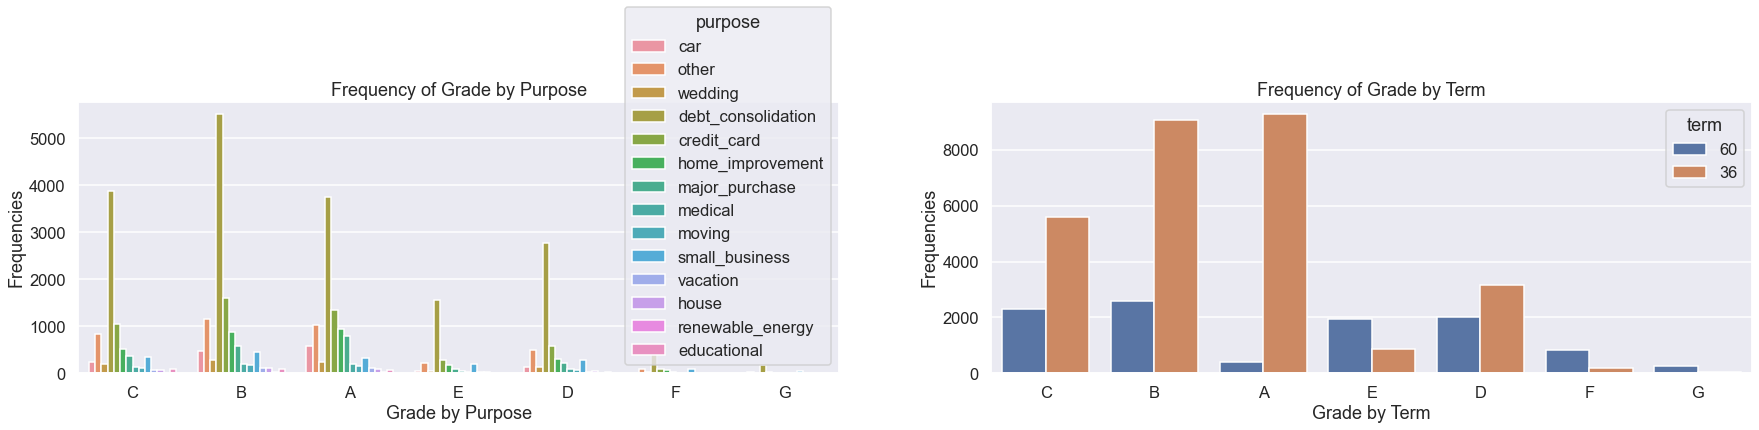

In [59]:
#Grade by purpose and term - Of all the grades , there is higher frequencies for debt consoldiation and credit card.
#Grade E & F have higher frequencies for longer duration , i.e 60 months than shorter duration , i.e 36 months
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
plt.title("Frequency of Grade by Purpose")
sns.countplot(x='grade',data=ft_data,hue='purpose')
plt.xlabel("Grade by Purpose")
plt.ylabel("Frequencies")
plt.subplot(1,2,2)
plt.title("Frequency of Grade by Term")
sns.countplot(x='grade',data=ft_data,hue='term')
plt.xlabel("Grade by Term")
plt.ylabel("Frequencies")
plt.show()

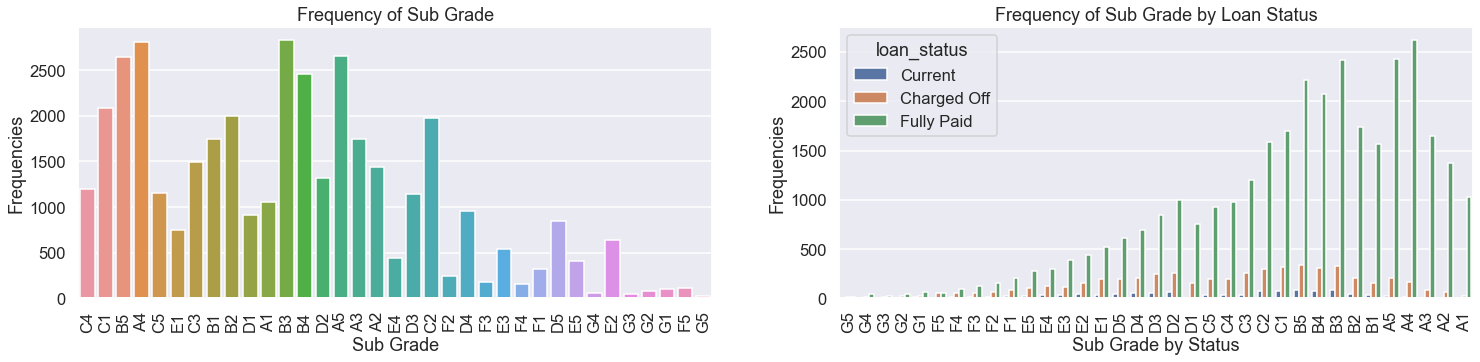

In [60]:
#Sub Grade Distribution - Most of the people belong to A4,A5,B3,B5
#Majority of Charged of Borrowers belongs to C1,B5,B3 & B4

plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Sub Grade")
sns.countplot(x='sub_grade',data=ft_data)
plt.xlabel("Sub Grade")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Sub Grade by Loan Status")
sns.countplot(x='sub_grade',data=ft_data.sort_values(by='sub_grade',ascending=False),hue='loan_status')
plt.xlabel("Sub Grade by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

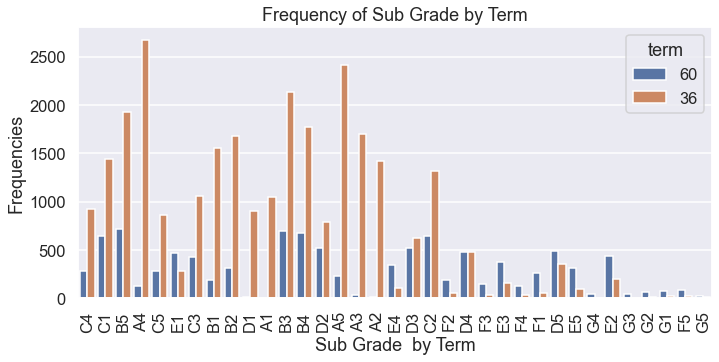

In [61]:
#Sub Grade Distribution By term - Majority of long term loan borrower lies in B3,B4,C2
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Sub Grade by Term")
sns.countplot(x='sub_grade',data=ft_data,hue='term')
plt.xlabel("Sub Grade  by Term")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)

plt.show()

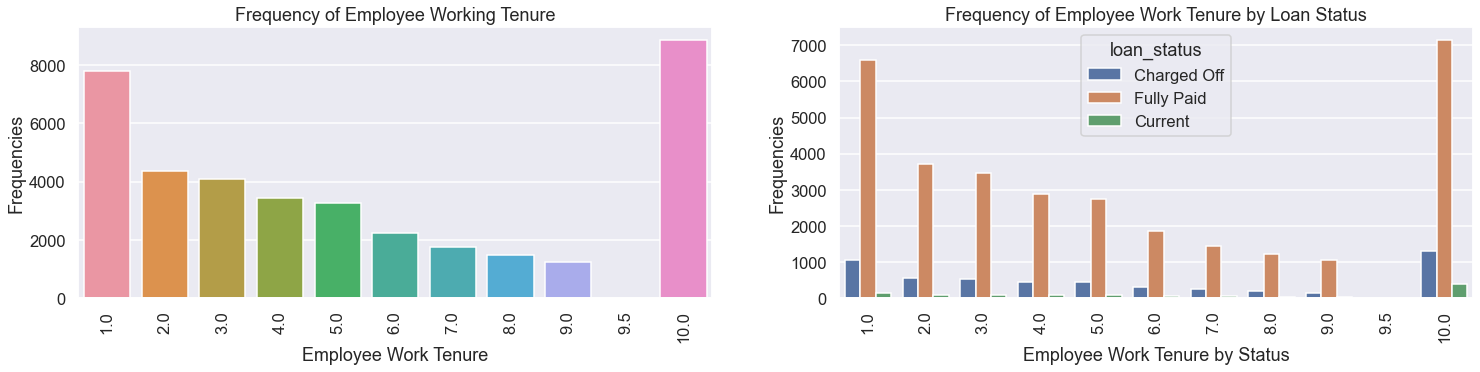

In [62]:
#Employee work tenure Distribution - 
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Employee Working Tenure")
sns.countplot(x='emp_length',data=ft_data)
plt.xlabel("Employee Work Tenure")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Employee Work Tenure by Loan Status")
sns.countplot(x='emp_length',data=ft_data,hue='loan_status')
plt.xlabel("Employee Work Tenure by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

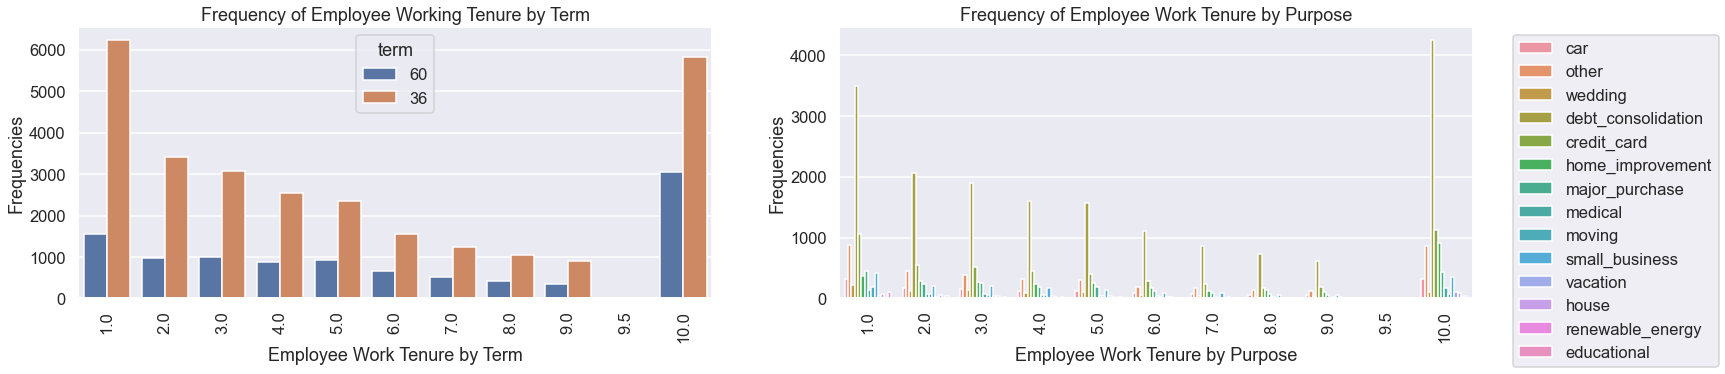

In [63]:
#Employee work tenure Distribution based on term and purpose
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Employee Working Tenure by Term")
sns.countplot(x='emp_length',data=ft_data,hue='term')
plt.xlabel("Employee Work Tenure by Term")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Employee Work Tenure by Purpose")
sns.countplot(x='emp_length',data=ft_data,hue='purpose')
plt.xlabel("Employee Work Tenure by Purpose")
plt.ylabel("Frequencies")
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xticks(rotation=90)
plt.show()

We see maximum working tenure of a borrower is of 10+ years. Borrowers of the same have been charged off the most!

Maximum 36 months and 60 months loans were taken by borrowers who had 10+ years experience

Majority of borrowers with 10+ years of experience , their purpose of loan was debt consolidatio

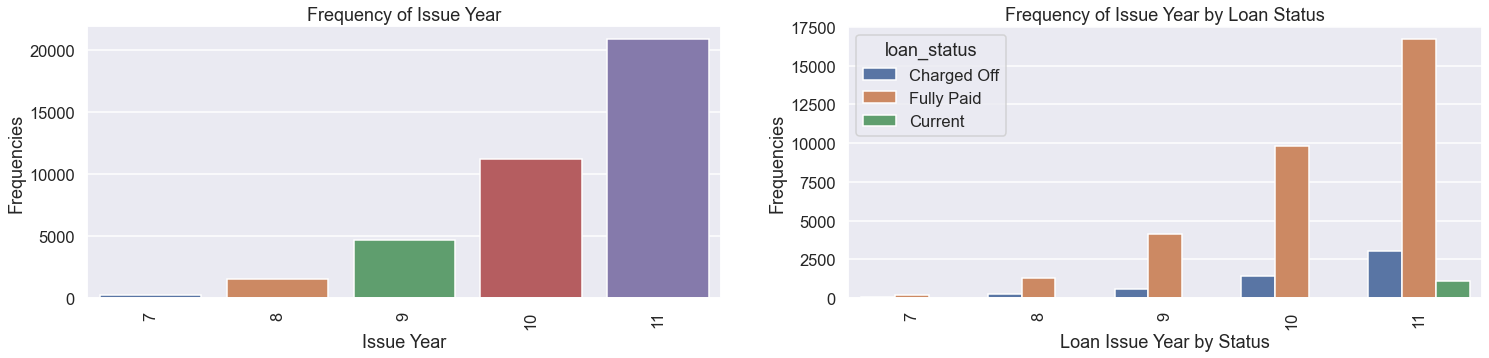

In [64]:
#Issue Year Distribution of Issue Year
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Issue Year")
sns.countplot(x='issue_d',data=ft_data)
plt.xlabel("Issue Year")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Issue Year by Loan Status")
sns.countplot(x='issue_d',data=ft_data,hue='loan_status')
plt.xlabel("Loan Issue Year by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

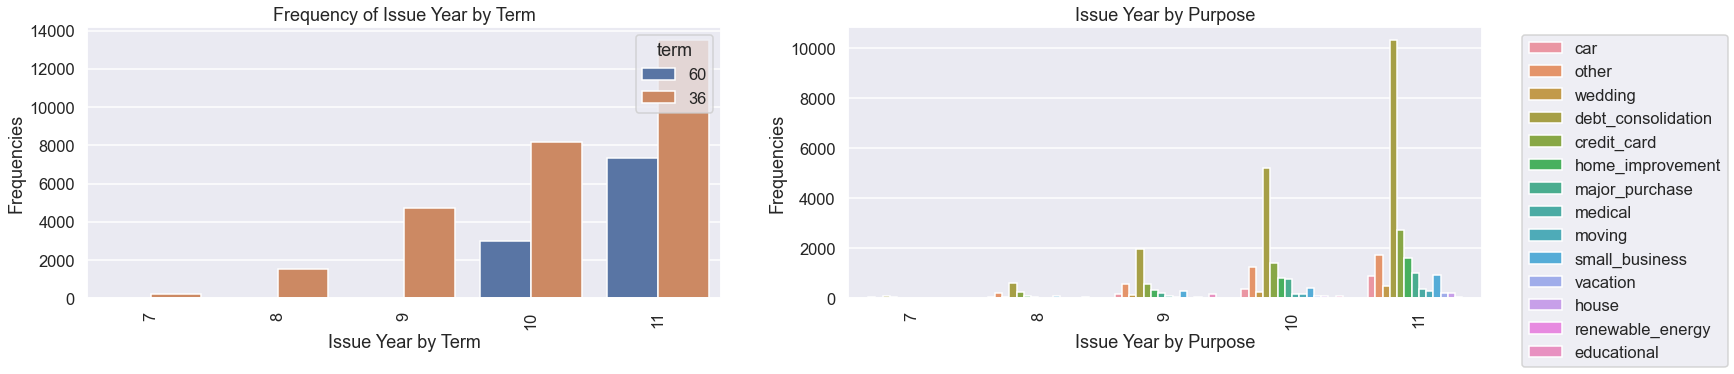

In [65]:
#Issue Year Distribution of Issue Year by Term and purpose
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Issue Year by Term")
sns.countplot(x='issue_d',data=ft_data,hue='term')
plt.xlabel("Issue Year by Term")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Issue Year by Purpose")
sns.countplot(x='issue_d',data=ft_data,hue='purpose')
plt.xlabel("Issue Year by Purpose")
plt.ylabel("Frequencies")
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.xticks(rotation=90)
plt.show()

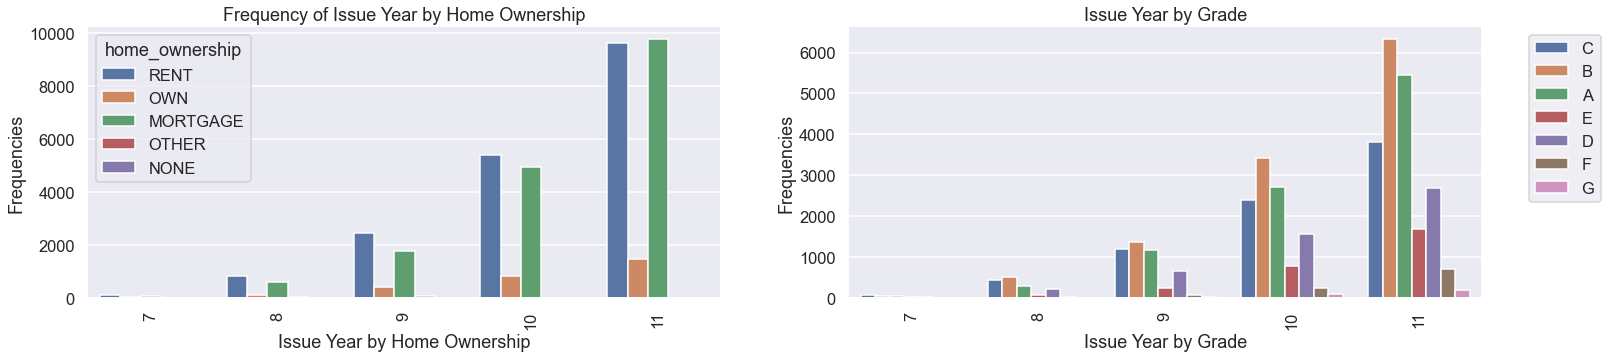

In [66]:
#Issue Year Distribution of Issue Year by home ownership and grade
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Issue Year by Home Ownership")
sns.countplot(x='issue_d',data=ft_data,hue='home_ownership')
plt.xlabel("Issue Year by Home Ownership")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Issue Year by Grade")
sns.countplot(x='issue_d',data=ft_data,hue='grade')
plt.xlabel("Issue Year by Grade")
plt.ylabel("Frequencies")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=90)
plt.show()

Most of the loans were issued in 2010 and 2011. Majority of charged off loans are in 2011 and 2010

60 months loans were only given in 2011 and 2010.

In 2011 and 2010 majority of loans were given for debt consolidation and credit card

In 2011 and 2010 majority of home ownership was either rented or mortgaged. And majority of them were having grade as B or A

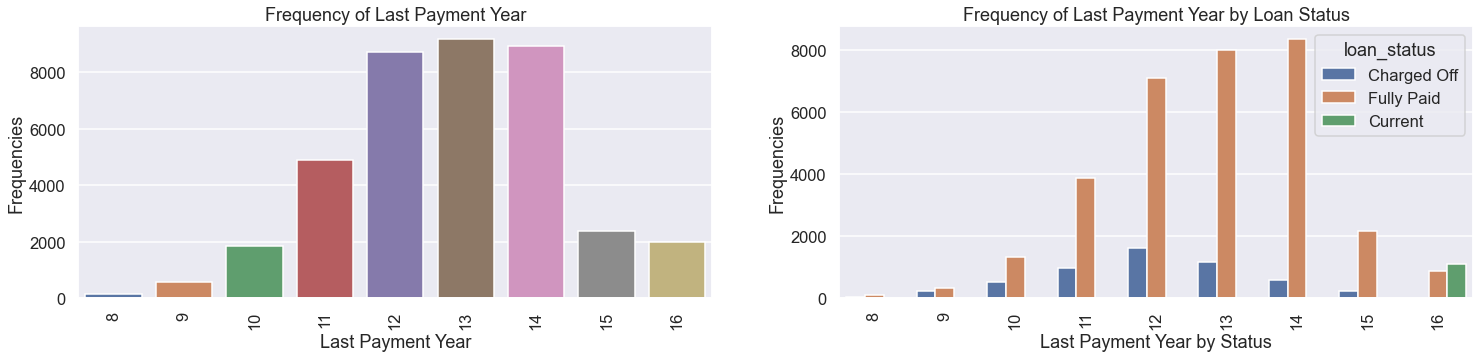

In [67]:
#Issue Year Distribution of Last Payment Year
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Payment Year")
sns.countplot(x='last_pymnt_yr',data=ft_data)
plt.xlabel("Last Payment Year")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Last Payment Year by Loan Status")
sns.countplot(x='last_pymnt_yr',data=ft_data,hue='loan_status')
plt.xlabel("Last Payment Year by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

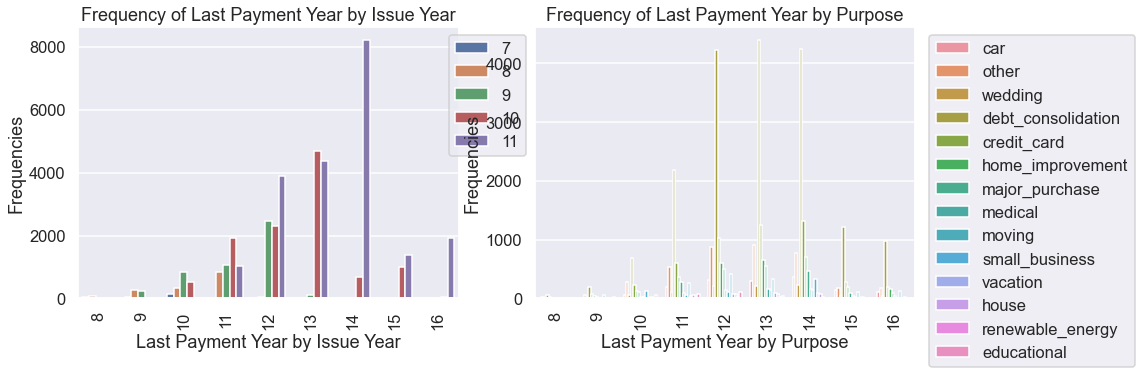

In [69]:
#Issue Year Distribution of Last Payment Year by issue year and purpose
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Payment Year by Issue Year")
sns.countplot(x='last_pymnt_yr',data=ft_data,hue='issue_d')
plt.xlabel("Last Payment Year by Issue Year")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.subplot(1,2,2)
plt.title("Frequency of Last Payment Year by Purpose")
sns.countplot(x='last_pymnt_yr',data=ft_data,hue='purpose')
plt.xlabel("Last Payment Year by Purpose")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
plt.show()

Majority of charged off borrowers are those who had made last payment in years between 2010 to 2014

Majority of borrowers who had made last payment in years between 2010 to 2014, got loan issued in 2010,2011 and 2009. Majority of last payments were made in lieu of debt consolidation and credit card

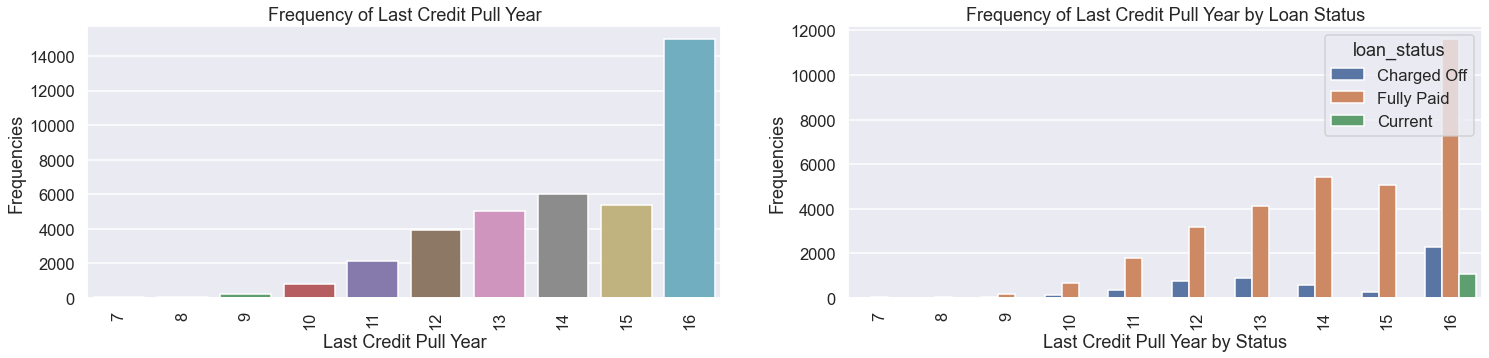

In [70]:
#Issue Year Distribution of Last Credit Pull Year  - In years 2016,2013,2012 of last credit pull year there were maximum charged off borrowers
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Credit Pull Year")
sns.countplot(x='last_credit_pull_yr',data=ft_data)
plt.xlabel("Last Credit Pull Year")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Last Credit Pull Year by Loan Status")
sns.countplot(x='last_credit_pull_yr',data=ft_data,hue='loan_status')
plt.xlabel("Last Credit Pull Year by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

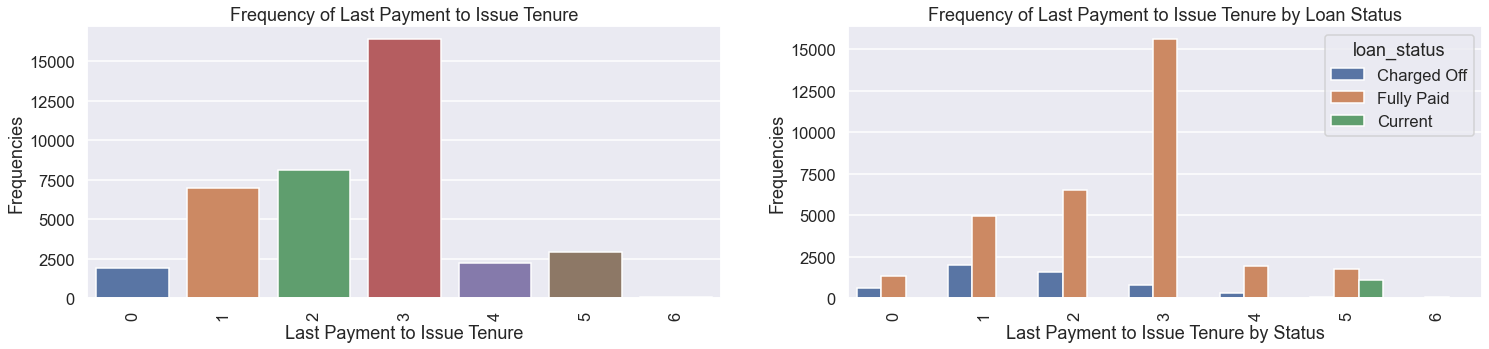

In [71]:
#Issue Year Distribution of Last Payment to Tenure - There were maximum charged off borrowers seen for the tenure from the last payment to issue of 1 and 2 year(s)
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Payment to Issue Tenure")
sns.countplot(x='last_pymnt_to_issue_Tenure',data=ft_data)
plt.xlabel("Last Payment to Issue Tenure")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Last Payment to Issue Tenure by Loan Status")
sns.countplot(x='last_pymnt_to_issue_Tenure',data=ft_data,hue='loan_status')
plt.xlabel("Last Payment to Issue Tenure by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

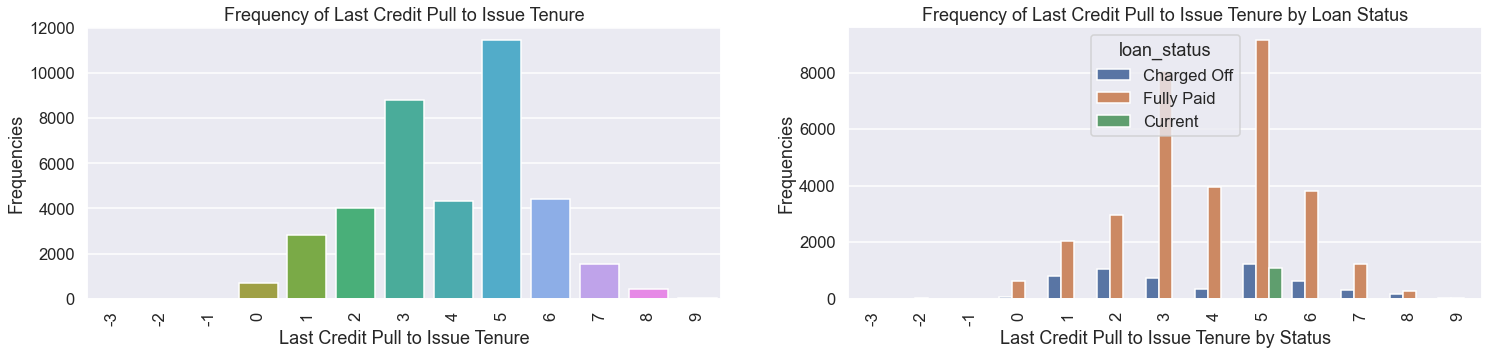

In [72]:
#Issue Year Distribution of Last Credit Pull to issue Tenure - For 1,2,3,5 & 6 years of last credit pull to issue tenure we see majority of charged off borrowers
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Credit Pull to Issue Tenure")
sns.countplot(x='LC_pull_to_issue_Tenure',data=ft_data)
plt.xlabel("Last Credit Pull to Issue Tenure")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Last Credit Pull to Issue Tenure by Loan Status")
sns.countplot(x='LC_pull_to_issue_Tenure',data=ft_data,hue='loan_status')
plt.xlabel("Last Credit Pull to Issue Tenure by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.show()

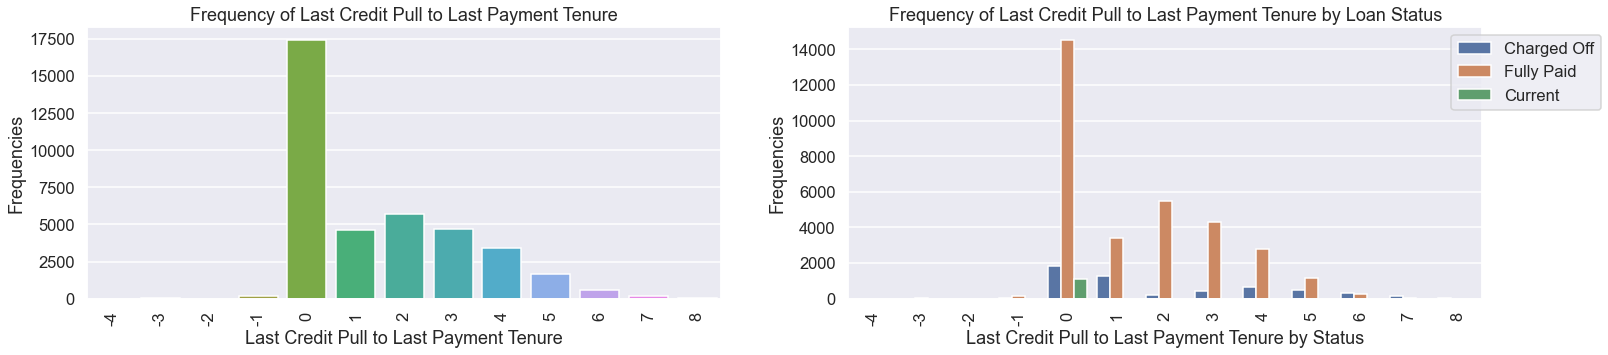

In [73]:
#Issue Year Distribution of Last Payment to Last Payment Tenure
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.title("Frequency of Last Credit Pull to Last Payment Tenure")
sns.countplot(x='LC_pull_to_pymnt_Tenure',data=ft_data)
plt.xlabel("Last Credit Pull to Last Payment Tenure")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.title("Frequency of Last Credit Pull to Last Payment Tenure by Loan Status")
sns.countplot(x='LC_pull_to_pymnt_Tenure',data=ft_data,hue='loan_status')
plt.xlabel("Last Credit Pull to Last Payment Tenure by Status")
plt.ylabel("Frequencies")
plt.xticks(rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

Most of the last credit pull to last payment tenure is of 0 years, i.e LC pulled the credit mostly in no gap from the last payment.

Major borrowers charged off during tenure of 0 & 1 years

In [6]:
def IQR(x):
    return x.quantile(.75)-x.quantile(.25)
def ninetynine_Perc(x):
    return x.quantile(.99)
def Range(x):
    return x.max()-x.min()

count    38648.000000
mean     10482.335270
std       5326.611335
min       3828.912097
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      18754.393637
Name: loan_amnt, dtype: float64


IQR of Loan Amount 9500.0


            loan_amnt                                                   \
             describe                                                    
                count          mean          std          min      25%   
loan_status                                                              
Charged Off    5401.0  11093.010425  5537.156905  3828.912097   6000.0   
Current        1099.0  14370.470815  4908.875506  3828.912097  12000.0   
Fully Paid    32148.0  10246.820853  5244.180512  3828.912097   5400.0   

                                                                \
                                                           IQR   
                 50%           75%           max     loan_amnt   
loan_status                                  

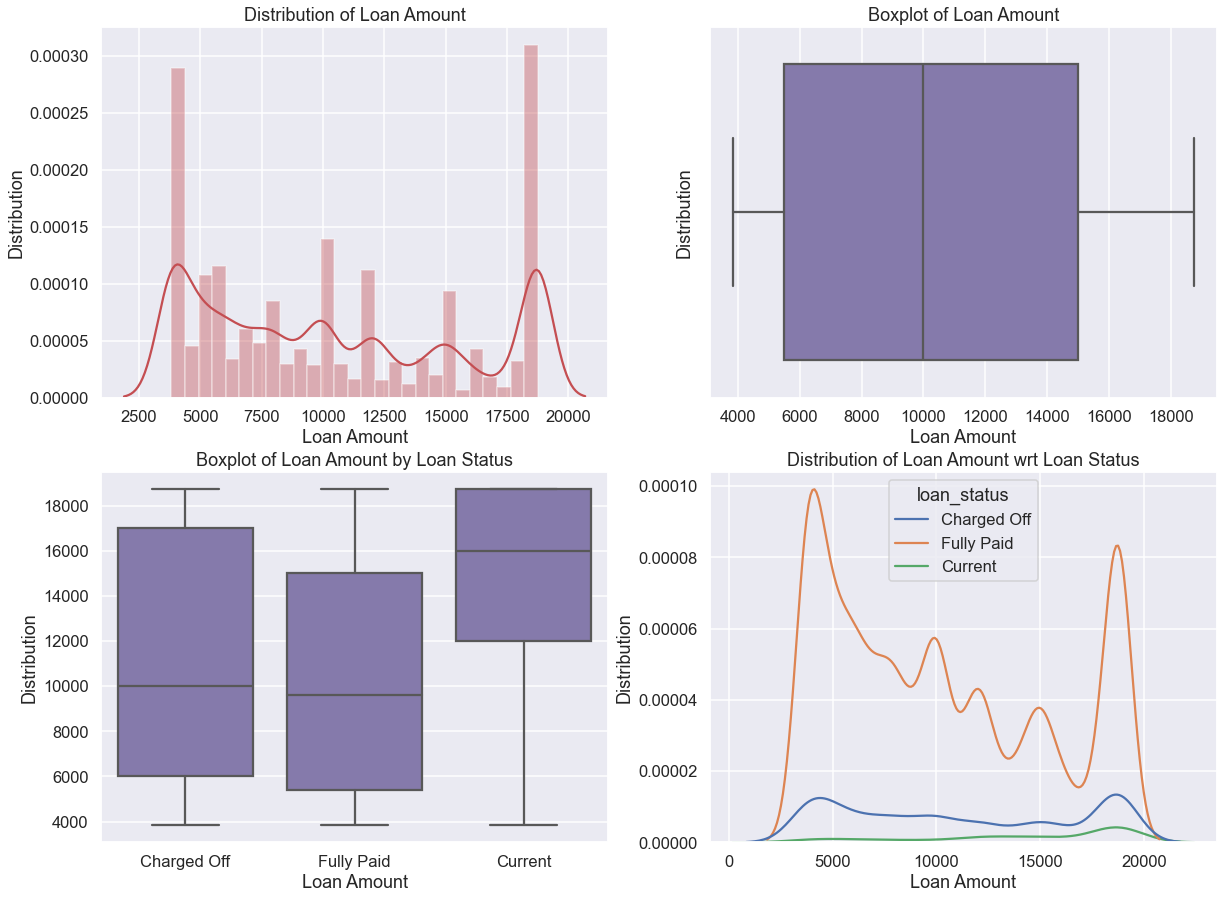

In [17]:
#Distribution of Loan Amount
print(ft_data['loan_amnt'].describe())
print('\n')
print("IQR of Loan Amount {0}".format(IQR(ft_data['loan_amnt'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'loan_amnt':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Loan Amount")
sns.distplot(ft_data['loan_amnt'],hist=True,kde=True,color='r')
plt.xlabel("Loan Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Loan Amount")
sns.boxplot(x='loan_amnt',data=ft_data,color='m')
plt.xlabel("Loan Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Loan Amount by Loan Status")
sns.boxplot(y='loan_amnt',x='loan_status',data=ft_data,color='m')
plt.xlabel("Loan Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Loan Amount wrt Loan Status")
sns.kdeplot(ft_data['loan_amnt'],hue=ft_data['loan_status'])
plt.xlabel('Loan Amount')
plt.ylabel("Distribution")
plt.show()

- Loan amount on the whole is not that skewed as mean and median are mostly similar

- 75% customers apply for loan amount within the range of 9500

- On the basis of loan status we find :

    - For charged off and fully paid loan amount is right/positive skewed
    - 75% of applicants in charged off apply for loan amount in the range of 11000 , which is higher than the range of fully paid. Which states that there is high variation in the charged off applicant group for loan amount
    - When we see the distribution plot of loan amount for each loan status type we find that loan amount curve for applicants who have fully paid have narrow peaks and there are around 5 peaks, which is suggestive of that there is not much variation in the loan amount but there are atleast 5 clusters of applicants within the data of Fully Paid. Whereas the distribution plot of charged off loan amount, it is very broad and shorter in height, which means there are lot of variance. and there are two peaks which is suggestive of atleast two clusters 
    
- We see that third quartile of loan amount for charged off borrowers is more than fully paid. Which states chance of defaulting is more , but there are 50% borrowers who could have avoided to default but they could not.



count    38648.000000
mean        12.050305
std          3.712298
min          5.420000
25%          9.320000
50%         11.860000
75%         14.590000
max         22.495000
Name: int_rate, dtype: float64


IQR of Interest Rate 5.27


            int_rate                                                          \
            describe                                                           
               count       mean       std   min    25%    50%    75%     max   
loan_status                                                                    
Charged Off   5401.0  13.878060  3.629492  5.42  11.46  13.61  16.45  22.495   
Current       1099.0  15.085901  3.556831  6.00  11.99  14.65  17.99  22.495   
Fully Paid   32148.0  11.639461  3.588544  5.42   8.59  11.49  13.99  22.495   

                                                         
                 IQR ninetynine_Perc    Range      skew  
            int_rate        int_rate int_rate  int_rate  
loan_status                 

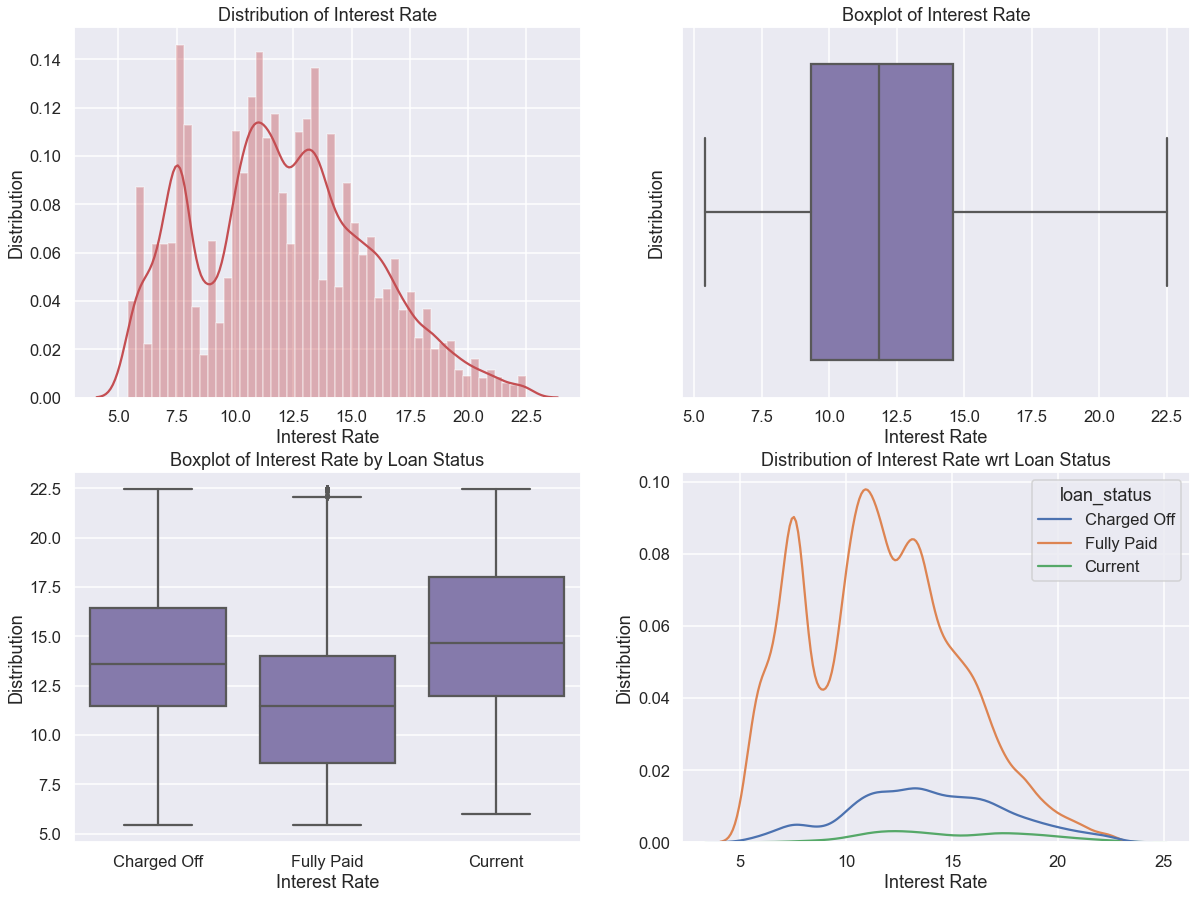

In [18]:
#Distribution of Interest rate
print(ft_data['int_rate'].describe())
print('\n')
print("IQR of Interest Rate {0}".format(IQR(ft_data['int_rate'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'int_rate':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Interest Rate")
sns.distplot(ft_data['int_rate'],hist=True,kde=True,color='r')
plt.xlabel("Interest Rate")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Interest Rate")
sns.boxplot(x='int_rate',data=ft_data,color='m')
plt.xlabel("Interest Rate")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Interest Rate by Loan Status")
sns.boxplot(y='int_rate',x='loan_status',data=ft_data,color='m')
plt.xlabel("Interest Rate")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Interest Rate wrt Loan Status")
sns.kdeplot(ft_data['int_rate'],hue=ft_data['loan_status'])
plt.xlabel('Interest Rate')
plt.ylabel("Distribution")
plt.show()

- When we see the distribution of interest rate we see it is positive skewed, that is you will find the applicants having high high interest rates will be driving the factor towards them. Variation on the whole is 5.27

- There is high variation in interest rate of those who have fully paid their debt, since IQR for them is 5.4, which means 75% of applicants in fully paid group lie in the range of 5.4 as interest rate. But within the bracket, the interest rates are lesser as when we compare to the interest rate in the same bracket

- To the very contrast the 99% of people in charged off category lies under interest rate of 22.1 but 99% of fully paid clients lies under interest rate of 20.5. Which is suggestive of the top 25% of applicants who are being charged off had availed loan in inflated interest rate that is very high interest rate

- We see that there is high variance in distribution plot for interest rate with charged off category, for fully paid we see there is less variation and there are minimum of 2 internal clusters 

count    38648.000000
mean       304.914489
std        147.740552
min        117.603382
25%        168.430000
50%        282.760000
75%        434.400000
max        535.905942
Name: installment, dtype: float64


IQR of installment 265.96999999999997


            installment                                                      \
               describe                                                       
                  count        mean         std         min     25%     50%   
loan_status                                                                   
Charged Off      5401.0  314.114459  151.038128  117.603382  171.48  297.53   
Current          1099.0  366.309727  143.675703  117.603382  260.85  370.22   
Fully Paid      32148.0  301.270019  146.789724  117.603382  166.50  277.63   

                                                                          \
                                         IQR ninetynine_Perc       Range   
                 75%         max installme

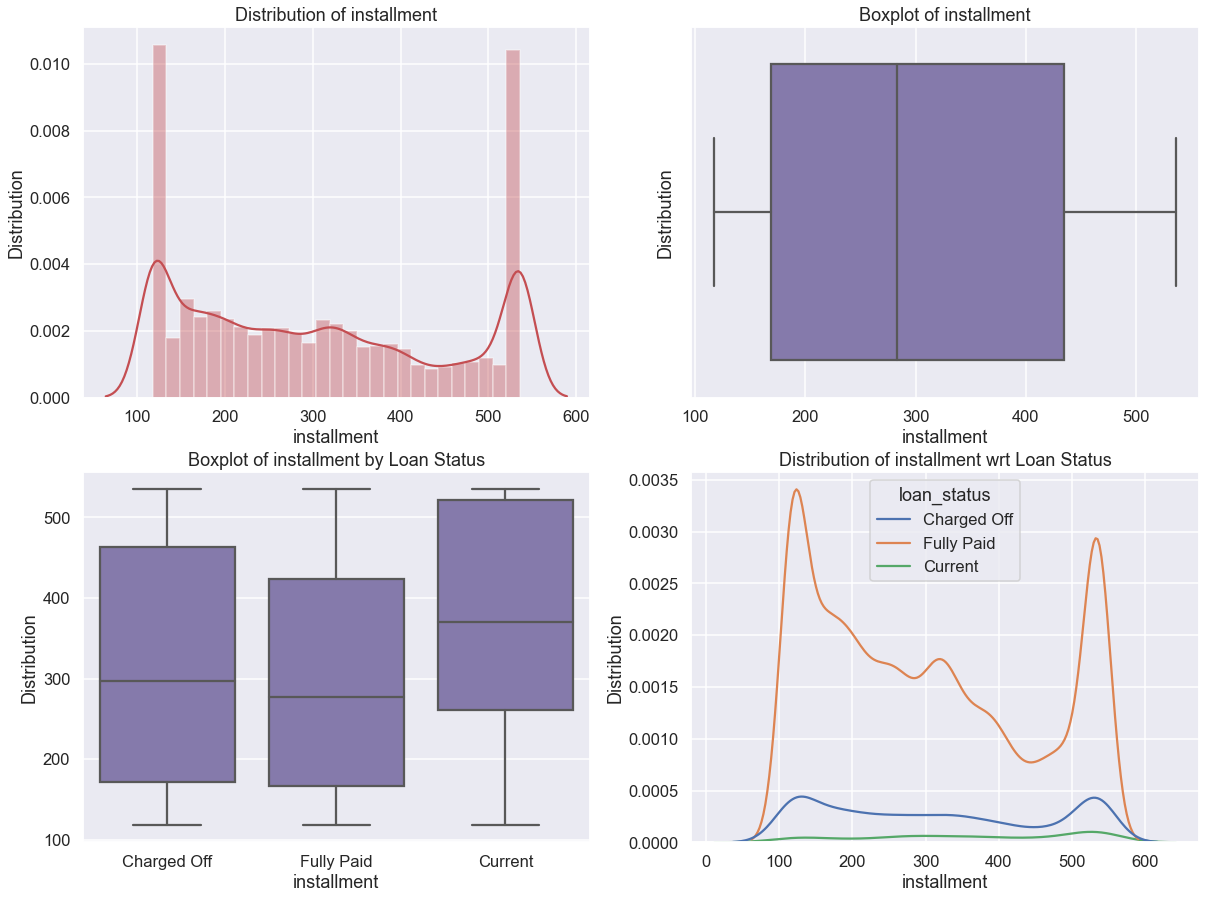

In [19]:
#Distribution of Installments
print(ft_data['installment'].describe())
print('\n')
print("IQR of installment {0}".format(IQR(ft_data['installment'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'installment':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of installment")
sns.distplot(ft_data['installment'],hist=True,kde=True,color='r')
plt.xlabel("installment")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of installment")
sns.boxplot(x='installment',data=ft_data,color='m')
plt.xlabel("installment")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of installment by Loan Status")
sns.boxplot(y='installment',x='loan_status',data=ft_data,color='m')
plt.xlabel("installment")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of installment wrt Loan Status")
sns.kdeplot(ft_data['installment'],hue=ft_data['loan_status'])
plt.xlabel('installment')
plt.ylabel("Distribution")
plt.show()

- We see data is bit right skewed

- On an average applicant pays installment of 282

- Variation in installemnt is 265.9, which means it captures 50% of the borrowers installments

- Borrowers of charged off category have high variation in their installment. Which states that borrowers tend to pay more installment amount than others. Reason for high installment value is higher interest rate also .


count    38648.000000
mean     62382.634895
std      22532.637923
min      33976.718466
25%      41354.400000
50%      60000.000000
75%      83196.000000
max      96433.073750
Name: annual_inc, dtype: float64


IQR of Annual Income 41841.6


            annual_inc                                                     \
              describe                                                      
                 count          mean           std           min      25%   
loan_status                                                                 
Charged Off     5401.0  58636.879794  21803.082233  33976.718466  38220.0   
Current         1099.0  67166.230272  22037.688051  33976.718466  48000.0   
Fully Paid     32148.0  62848.407322  22596.053471  33976.718466  42000.0   

                                                                       \
                                                  IQR ninetynine_Perc   
                 50%      75%          max annual_inc      annual_inc   

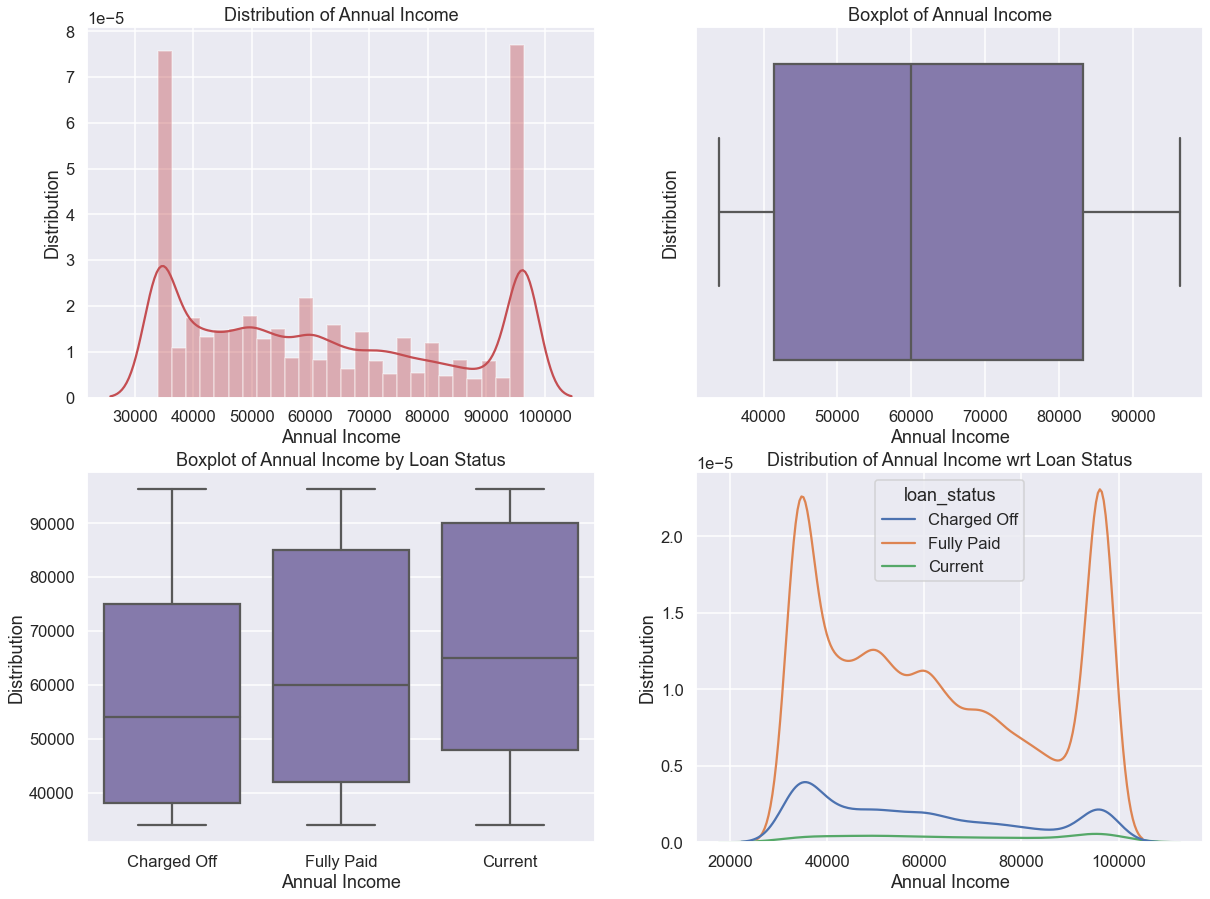

In [20]:
#Distribution of Annual Income
print(ft_data['annual_inc'].describe())
print('\n')
print("IQR of Annual Income {0}".format(IQR(ft_data['annual_inc'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'annual_inc':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Annual Income")
sns.distplot(ft_data['annual_inc'],hist=True,kde=True,color='r')
plt.xlabel("Annual Income")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Annual Income")
sns.boxplot(x='annual_inc',data=ft_data,color='m')
plt.xlabel("Annual Income")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Annual Income by Loan Status")
sns.boxplot(y='annual_inc',x='loan_status',data=ft_data,color='m')
plt.xlabel("Annual Income")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Annual Income wrt Loan Status")
sns.kdeplot(ft_data['annual_inc'],hue=ft_data['loan_status'])
plt.xlabel('Annual Income')
plt.ylabel("Distribution")
plt.show()

Data seems to be right skewed

Average annual income of borrower is 60000

Variation in annual income is 41841.6

We see that that there is increase in Q1,Q2 and Q3 in fully paid borrower than borrowers who are being charged off. It is suggestive of that borrowers who have higher annual income tend not to default . 

We can see the Third Quantile and First Quantile decreases from fully paid to charged off, it means that the borrowers which are charged off they do not belong to sound income group. Such people income distribution is low , either they are not well experienced or they do not have good jobs.

There is high variation in annual income of charged off customers , which states that borrowers belong to varied income group, though there are people who have sound income , but still they could not managed to clear out the debt. 



count    38648.000000
mean        13.325358
std          6.667679
min          0.000000
25%          8.200000
50%         13.415000
75%         18.590000
max         29.990000
Name: dti, dtype: float64


IQR of Debt to Income 10.39


                 dti                                                        \
            describe                                                         
               count       mean       std  min    25%    50%    75%    max   
loan_status                                                                  
Charged Off   5401.0  13.980076  6.572633  0.0  9.050  14.29  19.25  29.85   
Current       1099.0  14.734732  6.741299  0.0  9.705  15.03  20.11  29.95   
Fully Paid   32148.0  13.167183  6.668840  0.0  8.020  13.21  18.40  29.99   

                                                      
                IQR ninetynine_Perc  Range      skew  
                dti             dti    dti       dti  
loan_status                                           

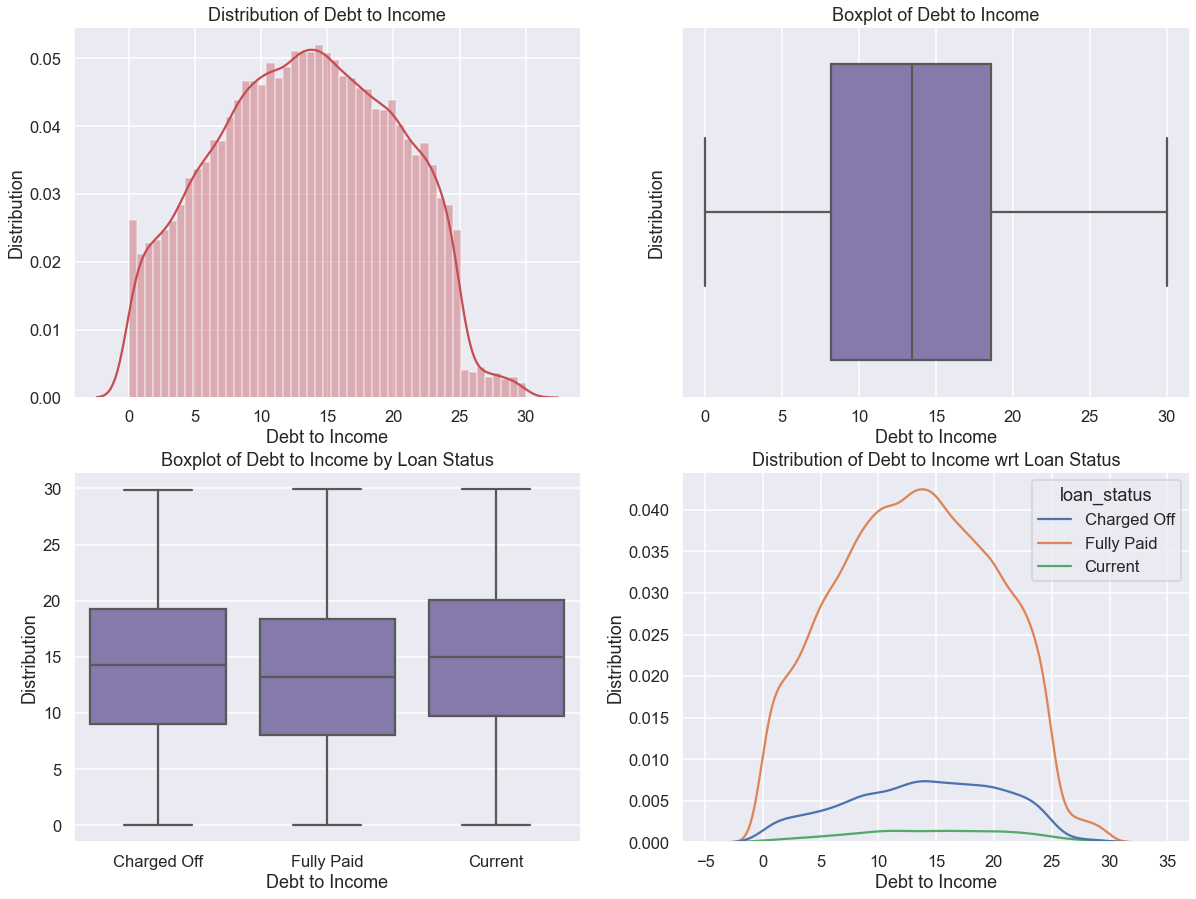

In [21]:
#Distribution of DTI
print(ft_data['dti'].describe())
print('\n')
print("IQR of Debt to Income {0}".format(IQR(ft_data['dti'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'dti':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Debt to Income")
sns.distplot(ft_data['dti'],hist=True,kde=True,color='r')
plt.xlabel("Debt to Income")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Debt to Income")
sns.boxplot(x='dti',data=ft_data,color='m')
plt.xlabel("Debt to Income")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Debt to Income by Loan Status")
sns.boxplot(y='dti',x='loan_status',data=ft_data,color='m')
plt.xlabel("Debt to Income")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Debt to Income wrt Loan Status")
sns.kdeplot(ft_data['dti'],hue=ft_data['loan_status'])
plt.xlabel('Debt to Income')
plt.ylabel("Distribution")
plt.show()

- Average contribution of dti of the applicant is on higher side for Charged Off category as compared to Fully paid, 

- which means those who are not likely to default are the ones who demonstrates a good balance between debt and income, 

- which means the those who have been charged off has too much debt for the amount of income earned each month. 

- Q3 and Q1 are decreasing for applicants belonging to Fully Paid category , 

- which means they have lesser debt as compared to income hence they can have more savings and can pay their debt 

- We can see that there is high variation in dti of fully paid slightly

count    38648.000000
mean         8.974826
std          3.113435
min          4.921966
25%          6.000000
50%          9.000000
75%         12.000000
max         13.712168
Name: open_acc, dtype: float64


IQR of Open Account 6.0


            open_acc                                                           \
            describe                                                            
               count      mean       std       min  25%  50%   75%        max   
loan_status                                                                     
Charged Off   5401.0  8.911225  3.134324  4.921966  6.0  9.0  12.0  13.712168   
Current       1099.0  9.478124  3.021026  4.921966  7.0  9.0  12.0  13.712168   
Fully Paid   32148.0  8.968306  3.111613  4.921966  6.0  9.0  12.0  13.712168   

                                                          
                 IQR ninetynine_Perc     Range      skew  
            open_acc        open_acc  open_acc  open_acc  
loan_status         

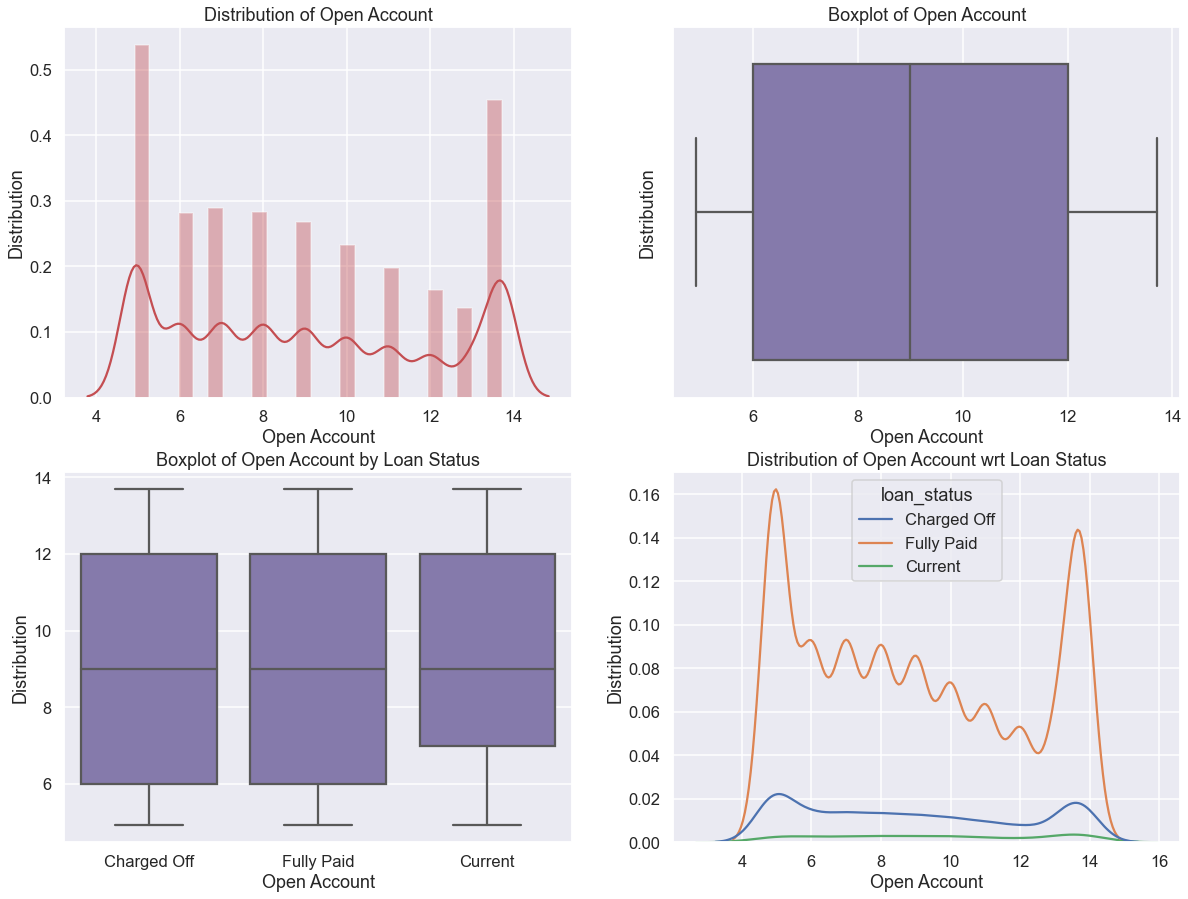

In [22]:
#Distribution of Open Account
print(ft_data['open_acc'].describe())
print('\n')
print("IQR of Open Account {0}".format(IQR(ft_data['open_acc'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'open_acc':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Open Account")
sns.distplot(ft_data['open_acc'],hist=True,kde=True,color='r')
plt.xlabel("Open Account")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Open Account")
sns.boxplot(x='open_acc',data=ft_data,color='m')
plt.xlabel("Open Account")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Open Account by Loan Status")
sns.boxplot(y='open_acc',x='loan_status',data=ft_data,color='m')
plt.xlabel("Open Account")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Open Account wrt Loan Status")
sns.kdeplot(ft_data['open_acc'],hue=ft_data['loan_status'])
plt.xlabel('Open Account')
plt.ylabel("Distribution")
plt.show()


Data is positive skewed

There is not much difference in the average of open account with respect to different loan statuses , hence it is not possible to state with surety that open account has any affect on loan status or no

count    38648.000000
mean     11365.465636
std       9202.078752
min          0.000000
25%       3745.000000
50%       8937.000000
75%      17149.250000
max      29370.943996
Name: revol_bal, dtype: float64


IQR of Revolving Balance 13404.25


            revol_bal                                                   \
             describe                                                    
                count          mean          std  min     25%      50%   
loan_status                                                              
Charged Off    5401.0  11690.357501  9246.719847  0.0  4015.0   9332.0   
Current        1099.0  14147.886806  9431.587498  0.0  6103.5  12837.0   
Fully Paid    32148.0  11215.763576  9170.294153  0.0  3636.0   8768.0   

                                                                            \
                                         IQR ninetynine_Perc         Range   
                 75%           max revol_bal       revol_bal     revol_bal   
l

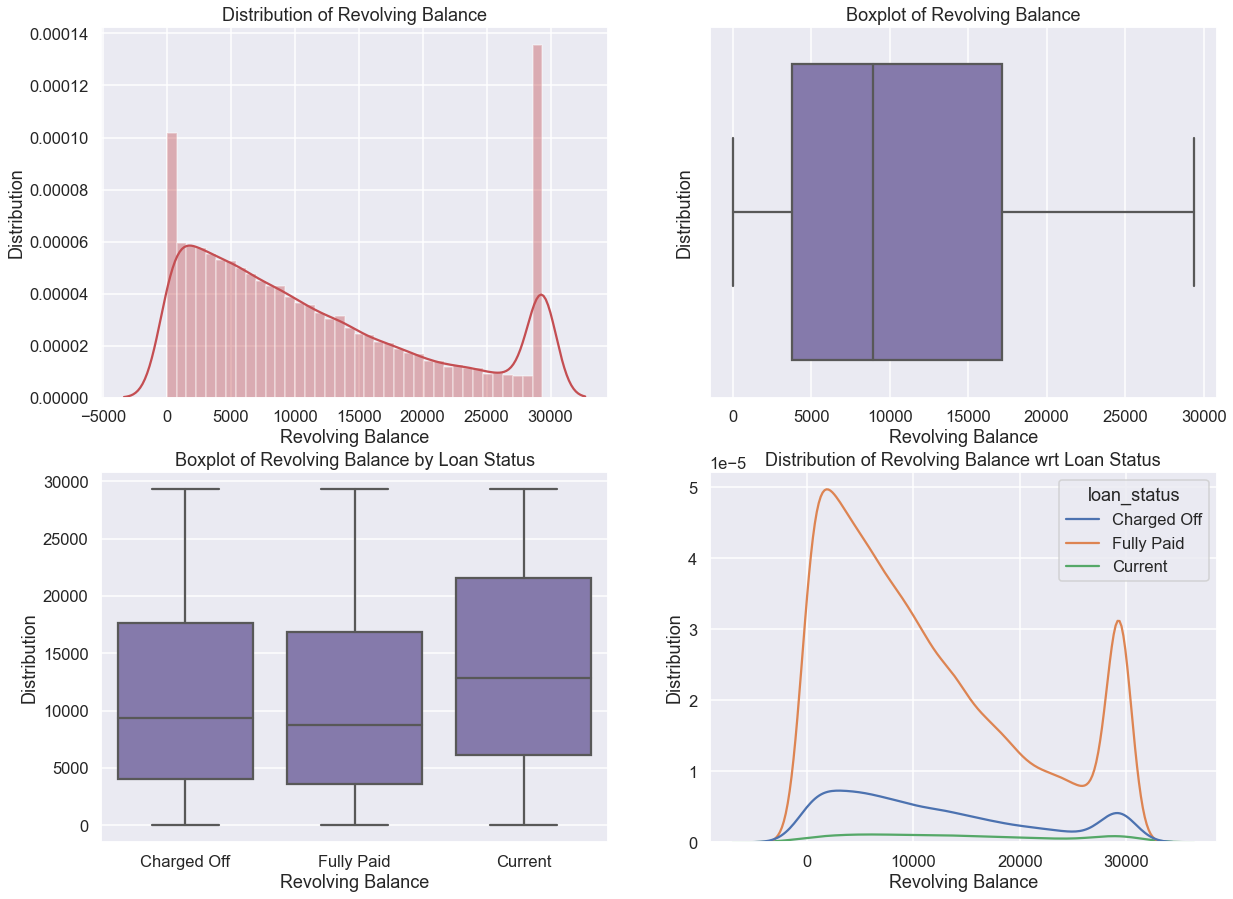

In [23]:
#Distribution of Revolving Balance
print(ft_data['revol_bal'].describe())
print('\n')
print("IQR of Revolving Balance {0}".format(IQR(ft_data['revol_bal'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'revol_bal':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Revolving Balance")
sns.distplot(ft_data['revol_bal'],hist=True,kde=True,color='r')
plt.xlabel("Revolving Balance")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Revolving Balance")
sns.boxplot(x='revol_bal',data=ft_data,color='m')
plt.xlabel("Revolving Balance")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Revolving Balance by Loan Status")
sns.boxplot(y='revol_bal',x='loan_status',data=ft_data,color='m')
plt.xlabel("Revolving Balance")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Revolving Balance wrt Loan Status")
sns.kdeplot(ft_data['revol_bal'],hue=ft_data['loan_status'])
plt.xlabel('Revolving Balance')
plt.ylabel("Distribution")
plt.show()

Data is right skewed

Average revolving balance - 8937

Variation in revolving balance - 13404

We can see highest variation in revolving balance of charged off borrowers , which means major portion of installments goes unpaid at the end of billing cycle. There are large number of people having high unpaid balance .

We see that Q3 of Charged Off borrowers is more than fully paid ,which states that chance of leaving the balance for next payment(revolving balance) is higher

count    38648.000000
mean        48.937988
std         28.340303
min          0.000000
25%         25.500000
50%         49.500000
75%         72.500000
max         99.900000
Name: revol_util, dtype: float64


IQR of Revolving Utilization 47.0


            revol_util                                                     \
              describe                                                      
                 count       mean        std  min   25%   50%   75%   max   
loan_status                                                                 
Charged Off     5401.0  55.594781  27.981868  0.0  34.4  58.6  79.1  99.9   
Current         1099.0  53.640227  26.696715  0.0  33.0  55.8  75.0  99.9   
Fully Paid     32148.0  47.658869  28.281910  0.0  24.1  47.8  70.9  99.9   

                                                              
                   IQR ninetynine_Perc      Range       skew  
            revol_util      revol_util revol_util revol_util  
loan_status             

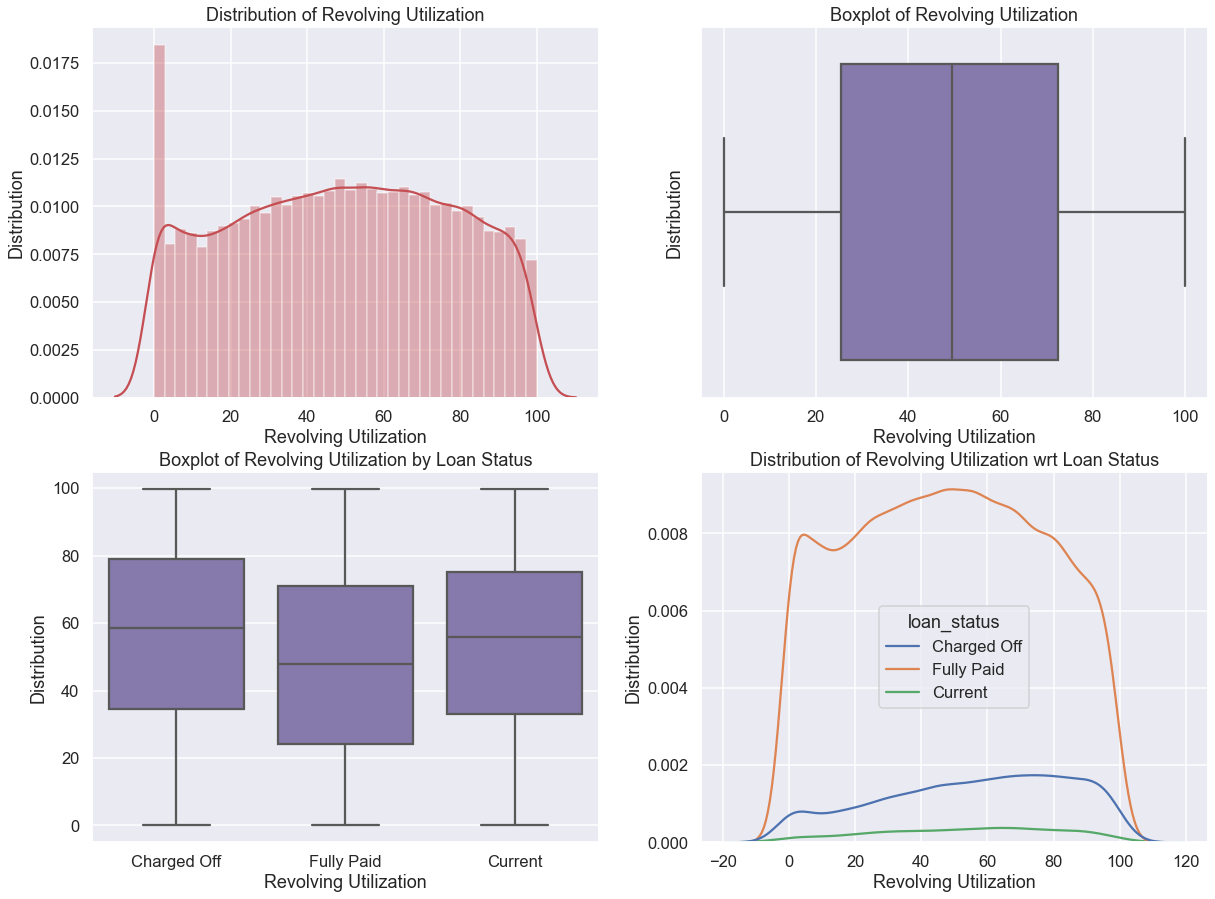

In [25]:
#Distribution of Revolving utilization
print(ft_data['revol_util'].describe())
print('\n')
print("IQR of Revolving Utilization {0}".format(IQR(ft_data['revol_util'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'revol_util':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Revolving Utilization")
sns.distplot(ft_data['revol_util'],hist=True,kde=True,color='r')
plt.xlabel("Revolving Utilization")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Revolving Utilization")
sns.boxplot(x='revol_util',data=ft_data,color='m')
plt.xlabel("Revolving Utilization")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Revolving Utilization by Loan Status")
sns.boxplot(y='revol_util',x='loan_status',data=ft_data,color='m')
plt.xlabel("Revolving Utilization")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Revolving Utilization wrt Loan Status")
sns.kdeplot(ft_data['revol_util'],hue=ft_data['loan_status'])
plt.xlabel('Revolving Utilization')
plt.ylabel("Distribution")
plt.show()

Data skewness is not present

Average credit utilization rate is 49.5, variation is 47

Borrowers who were charged off had higher revolving utilization , i.e credit utilization which is 58.6, which means there was less difference in their debt and credit limit.

Though there is high variation in revolving utilization for borrowers which were fully paid, but borrowers who were charged off comparitively had high revolving utilization rate.

count    38648.000000
mean        21.304326
std          8.201686
min         10.727564
25%         14.000000
50%         20.000000
75%         29.000000
max         33.514156
Name: total_acc, dtype: float64


IQR of Total Account 15.0


            total_acc                                                    \
             describe                                                     
                count       mean       std        min   25%   50%   75%   
loan_status                                                               
Charged Off    5401.0  20.858257  8.325317  10.727564  13.0  20.0  29.0   
Current        1099.0  22.495822  7.842342  10.727564  16.0  22.0  30.0   
Fully Paid    32148.0  21.338536  8.187943  10.727564  14.0  21.0  29.0   

                                                                       
                             IQR ninetynine_Perc      Range      skew  
                   max total_acc       total_acc  total_acc total_acc  
loan_status         

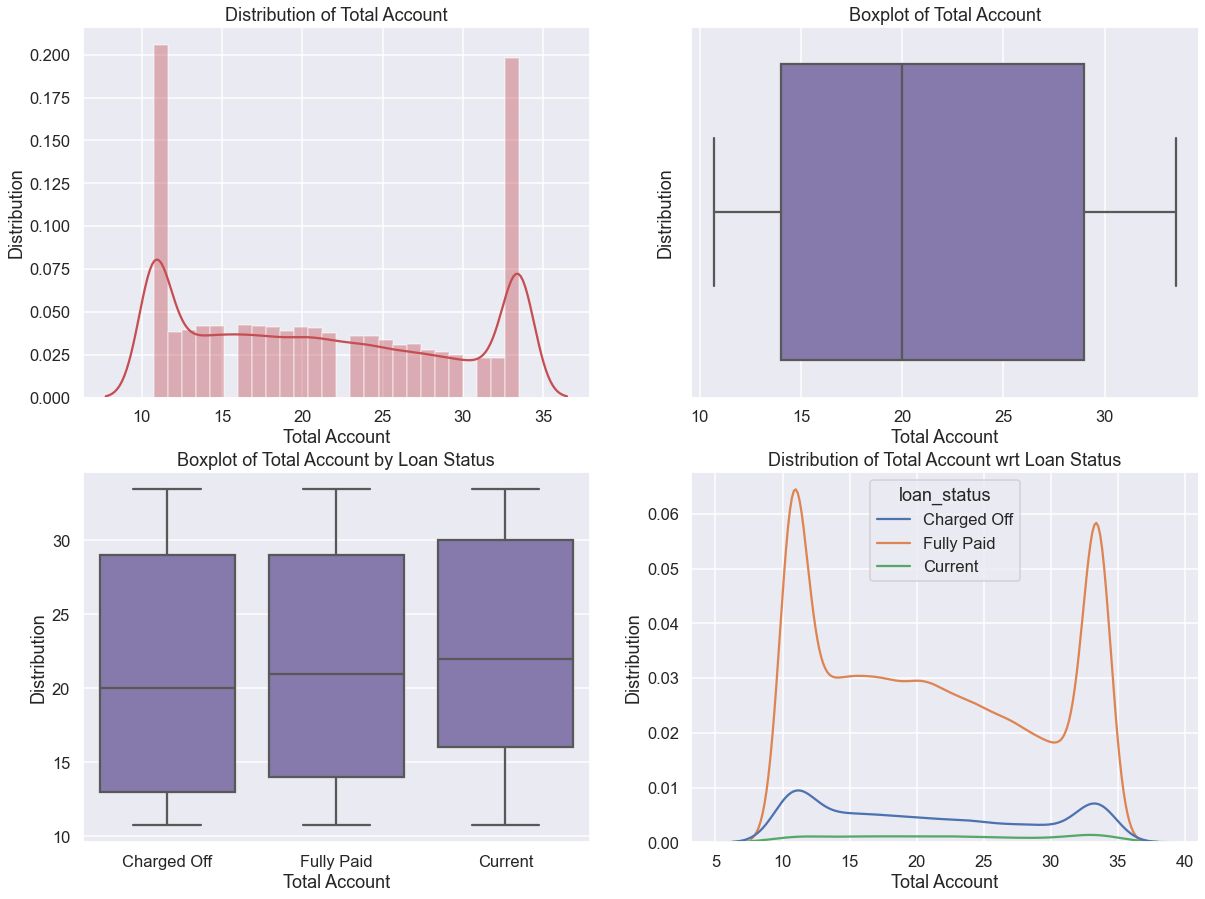

In [26]:
#Distribution of Total Account
print(ft_data['total_acc'].describe())
print('\n')
print("IQR of Total Account {0}".format(IQR(ft_data['total_acc'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'total_acc':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Total Account")
sns.distplot(ft_data['total_acc'],hist=True,kde=True,color='r')
plt.xlabel("Total Account")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Total Account")
sns.boxplot(x='total_acc',data=ft_data,color='m')
plt.xlabel("Total Account")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Total Account by Loan Status")
sns.boxplot(y='total_acc',x='loan_status',data=ft_data,color='m')
plt.xlabel("Total Account")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Total Account wrt Loan Status")
sns.kdeplot(ft_data['total_acc'],hue=ft_data['loan_status'])
plt.xlabel('Total Account')
plt.ylabel("Distribution")
plt.show()

Data is right skewed

Average total account is 20, variation is 15

Average of charged off and paid off  are almost similar , it can be because of randomness . Hence, can not say with surety about how total account affect loan status

There is not much large difference in variation also between the charged off category vs others .

count    38648.000000
mean         2.249145
std         13.170764
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         79.557020
Name: out_prncp, dtype: float64


IQR of Outstanding Principal 0.0


            out_prncp                                                  \
             describe                                                   
                count       mean       std    min       25%       50%   
loan_status                                                             
Charged Off    5401.0   0.000000  0.000000   0.00   0.00000   0.00000   
Current        1099.0  79.094606  4.701282  10.26  79.55702  79.55702   
Fully Paid    32148.0   0.000000  0.000000   0.00   0.00000   0.00000   

                                                                                
                                      IQR ninetynine_Perc     Range       skew  
                  75%       max out_prncp       out_prncp out_prncp  out_prncp  


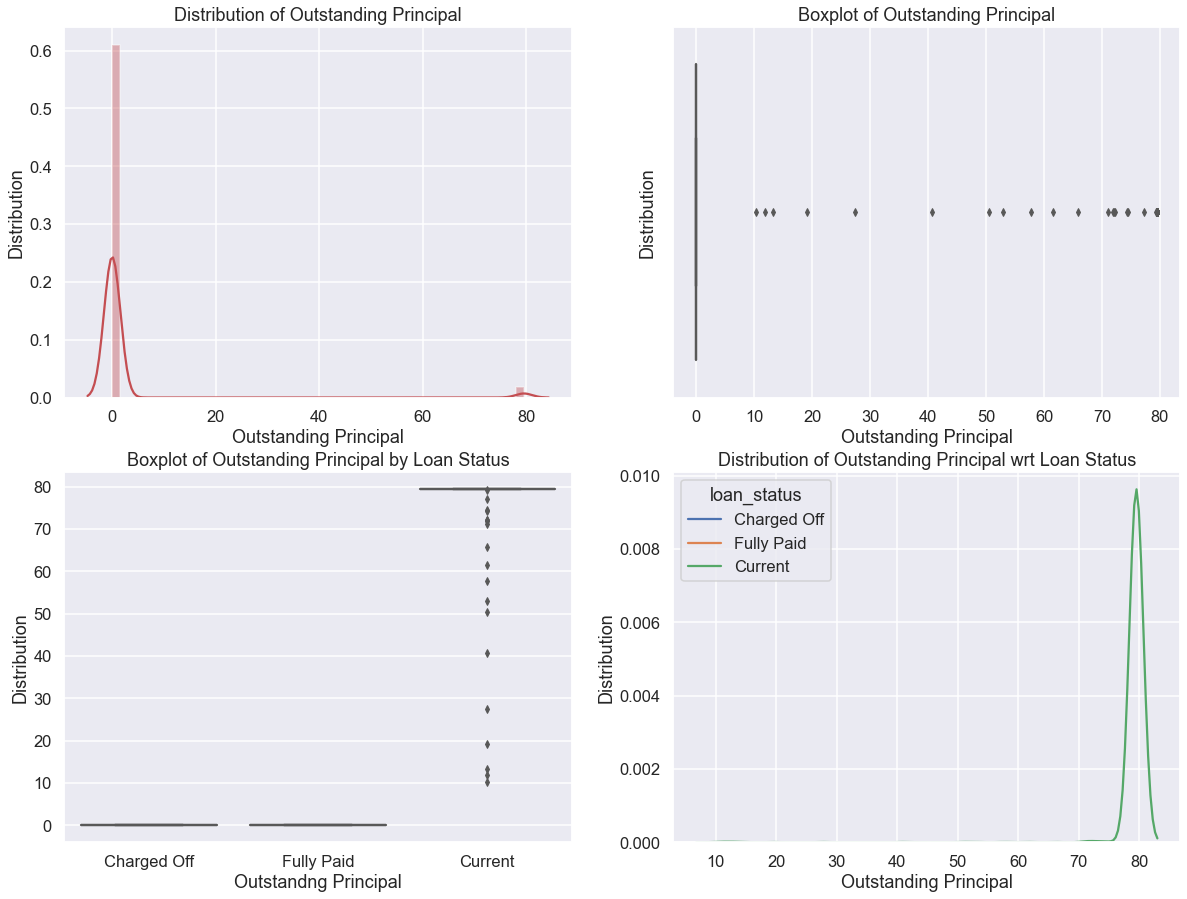

In [27]:
#Distribution of Outstaniding Principal
print(ft_data['out_prncp'].describe())
print('\n')
print("IQR of Outstanding Principal {0}".format(IQR(ft_data['out_prncp'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'out_prncp':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Outstanding Principal")
sns.distplot(ft_data['out_prncp'],hist=True,kde=True,color='r')
plt.xlabel("Outstanding Principal")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Outstanding Principal")
sns.boxplot(x='out_prncp',data=ft_data,color='m')
plt.xlabel("Outstanding Principal")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Outstanding Principal by Loan Status")
sns.boxplot(y='out_prncp',x='loan_status',data=ft_data,color='m')
plt.xlabel("Outstandng Principal")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Outstanding Principal wrt Loan Status")
sns.kdeplot(ft_data['out_prncp'],hue=ft_data['loan_status'])
plt.xlabel('Outstanding Principal')
plt.ylabel("Distribution")
plt.show()

The data is skewed

It backs up my earlier made inference that outstanding principal in data is for those borrowers who are current . There won't be any outstanding principal for fully paid or those who have got charged off.

count    38648.000000
mean       230.110238
std        863.675495
min          0.000000
25%          0.000000
50%          0.000000
75%          5.392117
max      14930.873656
Name: application_to_funded_diff, dtype: float64


IQR of Difference in Applied and Funded Amount 5.3921165890906195


            application_to_funded_diff                                         \
                              describe                                          
                                 count        mean         std  min  25%  50%   
loan_status                                                                     
Charged Off                     5401.0  270.520693  918.511506  0.0  0.0  0.0   
Current                         1099.0  339.701929  726.649328  0.0  0.0  0.0   
Fully Paid                     32148.0  219.574649  858.028364  0.0  0.0  0.0   

                                                                  \
                                                             IQR   
 

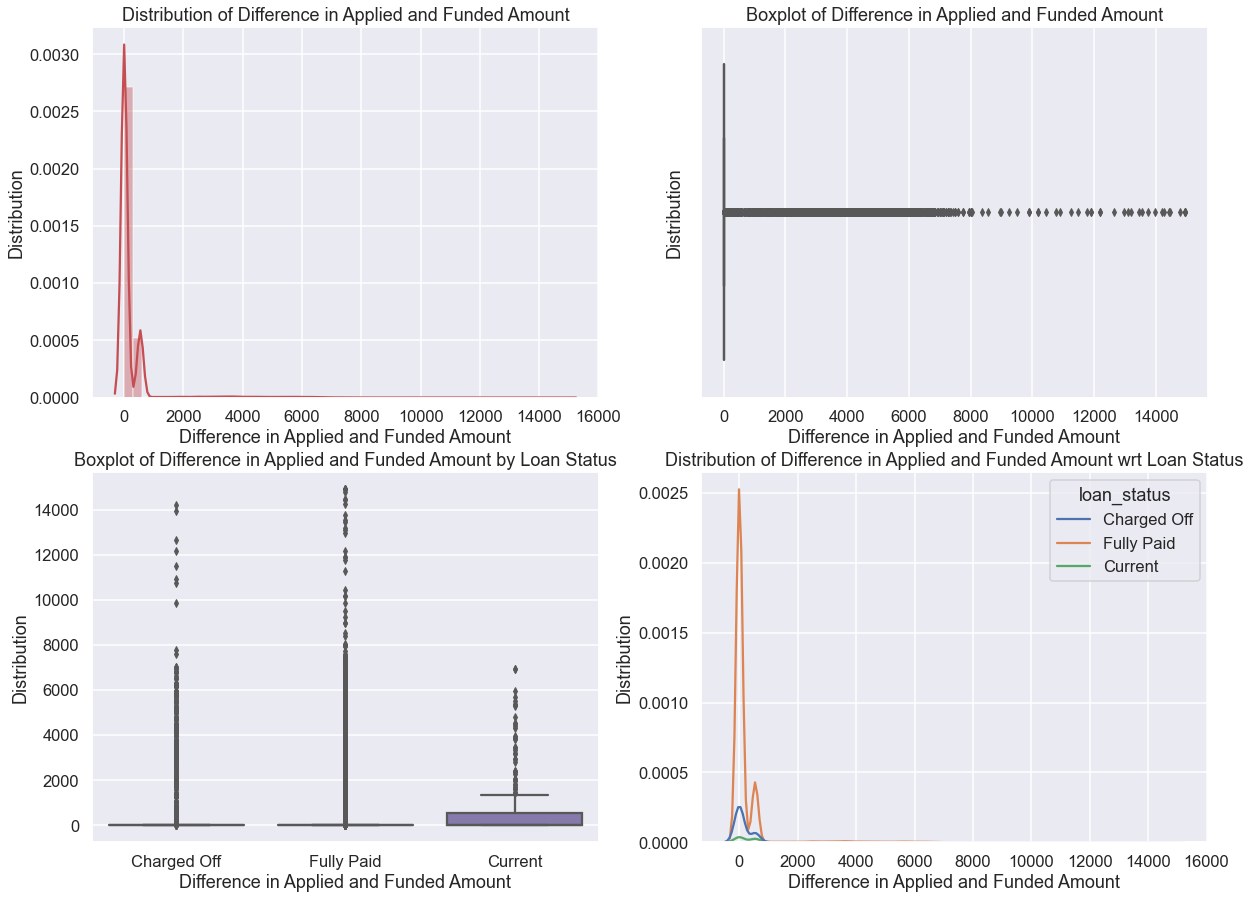

In [8]:
print(ft_data['application_to_funded_diff'].describe())
print('\n')
print("IQR of Difference in Applied and Funded Amount {0}".format(IQR(ft_data['application_to_funded_diff'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'application_to_funded_diff':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Difference in Applied and Funded Amount")
sns.distplot(ft_data['application_to_funded_diff'],hist=True,kde=True,color='r')
plt.xlabel("Difference in Applied and Funded Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Difference in Applied and Funded Amount")
sns.boxplot(x='application_to_funded_diff',data=ft_data,color='m')
plt.xlabel("Difference in Applied and Funded Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Difference in Applied and Funded Amount by Loan Status")
sns.boxplot(y='application_to_funded_diff',x='loan_status',data=ft_data,color='m')
plt.xlabel("Difference in Applied and Funded Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Difference in Applied and Funded Amount wrt Loan Status")
sns.kdeplot(ft_data['application_to_funded_diff'],hue=ft_data['loan_status'])
plt.xlabel('Difference in Applied and Funded Amount')
plt.ylabel("Distribution")
plt.show()

We see that there is difference in amount significantly for current borrowers. But when we compare charged off and fully paid , we see there is huge variation in fully paid

count    38648.000000
mean     13134.684892
std       7683.921390
min       4233.721757
25%       6960.600000
50%      11489.280000
75%      18745.650000
max      32154.356521
Name: total_inst, dtype: float64


IQR of Difference in Total Installment 11785.050000000003


            total_inst                                                    \
              describe                                                     
                 count          mean          std          min       25%   
loan_status                                                                
Charged Off     5401.0  14845.390451  8665.261209  4233.721757   7108.92   
Current         1099.0  21978.583642  8620.542157  7056.202928  15651.00   
Fully Paid     32148.0  12544.944770  7232.999507  4233.721757   6701.49   

                                                                 \
                                                            IQR   
                  50%           75%           max    total_ins

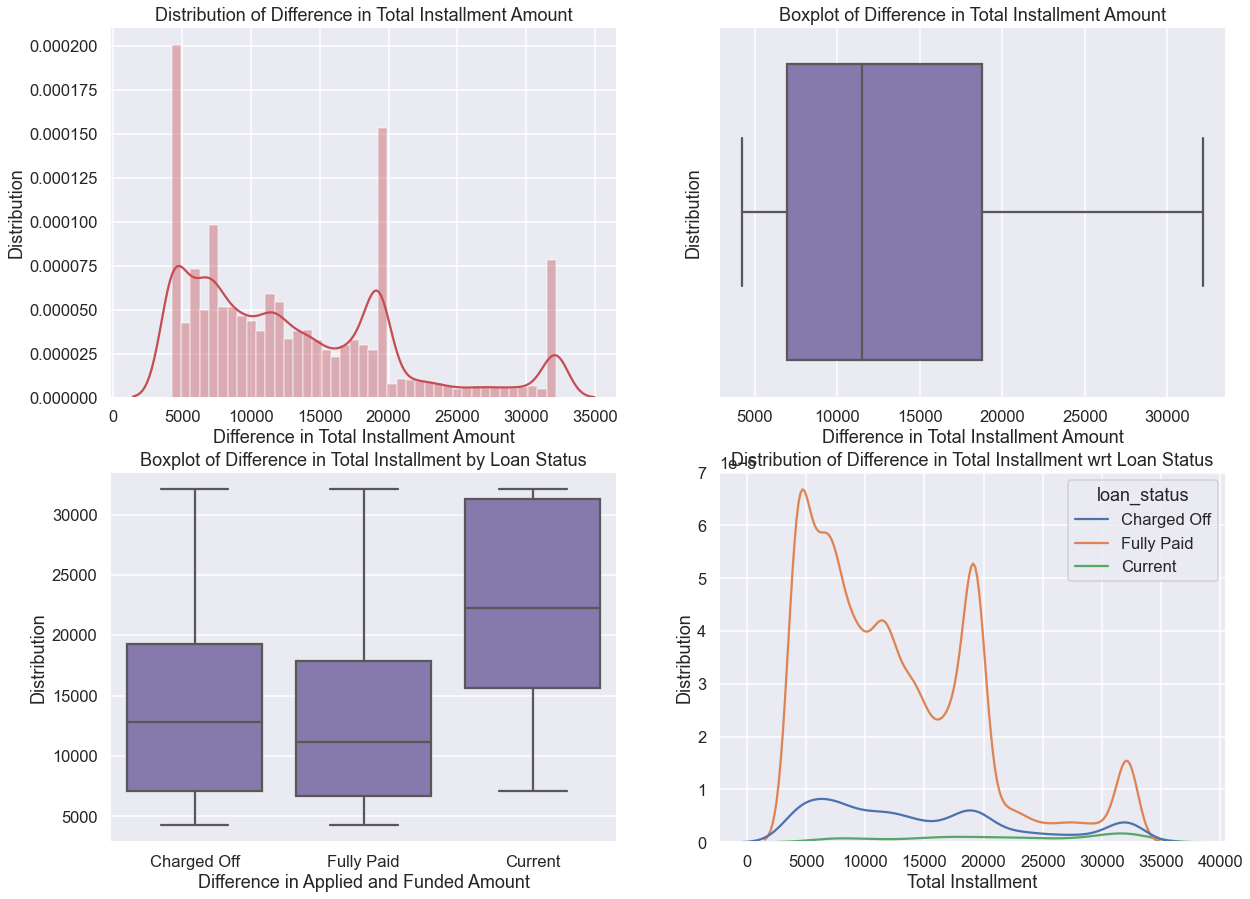

In [14]:
print(ft_data['total_inst'].describe())
print('\n')
print("IQR of Difference in Total Installment {0}".format(IQR(ft_data['total_inst'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'total_inst':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Difference in Total Installment Amount")
sns.distplot(ft_data['total_inst'],hist=True,kde=True,color='r')
plt.xlabel("Difference in Total Installment Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Difference in Total Installment Amount")
sns.boxplot(x='total_inst',data=ft_data,color='m')
plt.xlabel("Difference in Total Installment Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Difference in Total Installment by Loan Status")
sns.boxplot(y='total_inst',x='loan_status',data=ft_data,color='m')
plt.xlabel("Difference in Applied and Funded Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Difference in Total Installment wrt Loan Status")
sns.kdeplot(ft_data['total_inst'],hue=ft_data['loan_status'])
plt.xlabel('Total Installment')
plt.ylabel("Distribution")
plt.show()

Ideally borrowers who belong to charged off class had to pay higher total amount as compared to others. Q3 and Q1 both are greater than fully paid , which means those who defaults are likely to pay higher loan amount inclusive of interest

count    38648.000000
mean      1955.697959
std       4228.514867
min      -2156.118260
25%          0.230074
50%        334.917292
75%       1523.771462
max      28968.215738
Name: balance, dtype: float64


IQR of Balance Amount 1523.541388499999


             balance                                                      \
            describe                                                       
               count         mean          std          min          25%   
loan_status                                                                
Charged Off   5401.0  7684.511304  6644.263136 -2007.246112  2532.819217   
Current       1099.0  4780.004184  4177.688218  -747.520000  1128.330000   
Fully Paid   32148.0   896.682361  2564.321099 -2156.118260     0.104557   

                                                                   \
                                                              IQR   
                     50%           75%           max      balance   
loan_statu

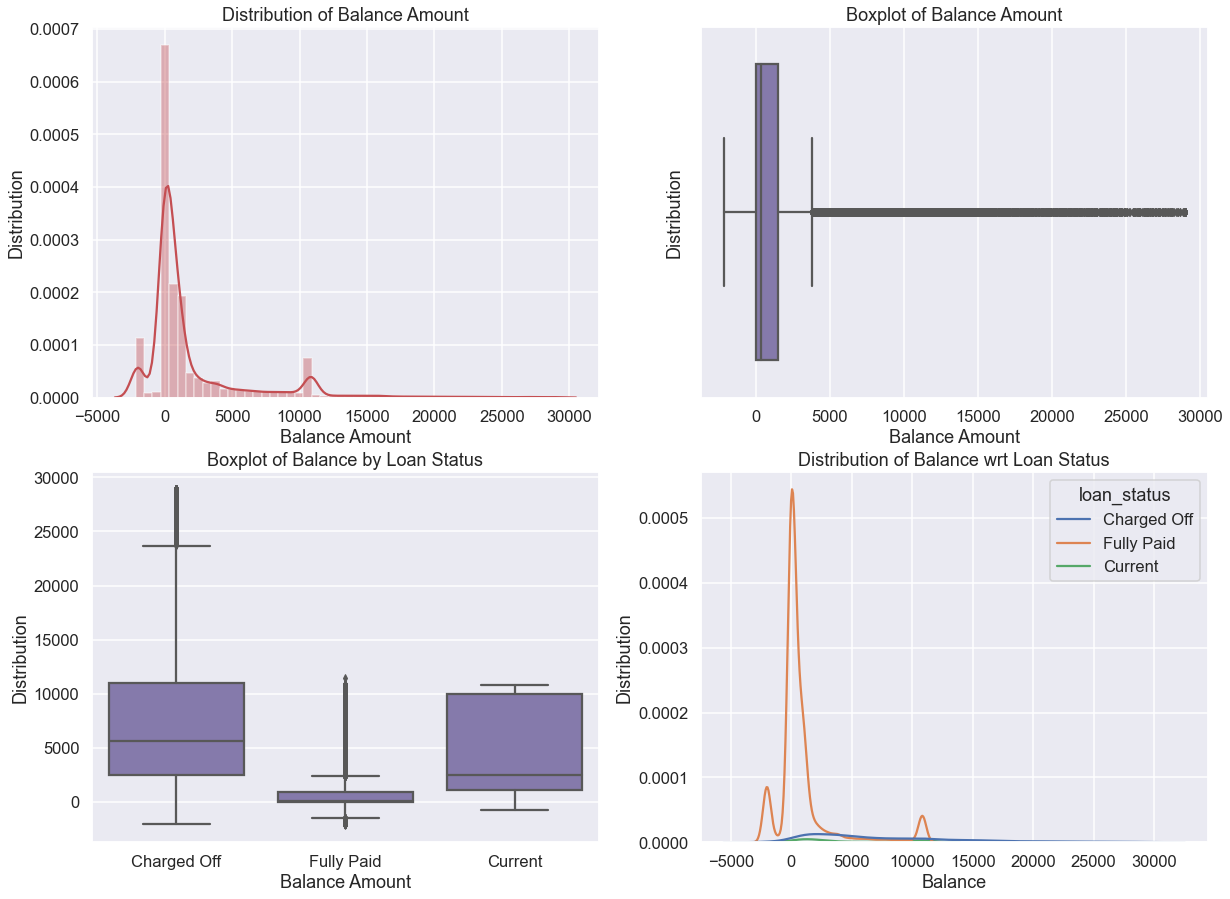

In [16]:
print(ft_data['balance'].describe())
print('\n')
print("IQR of Balance Amount {0}".format(IQR(ft_data['balance'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'balance':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Balance Amount")
sns.distplot(ft_data['balance'],hist=True,kde=True,color='r')
plt.xlabel("Balance Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Balance Amount")
sns.boxplot(x='balance',data=ft_data,color='m')
plt.xlabel("Balance Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Balance by Loan Status")
sns.boxplot(y='balance',x='loan_status',data=ft_data,color='m')
plt.xlabel("Balance Amount")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Distribution of Balance wrt Loan Status")
sns.kdeplot(ft_data['balance'],hue=ft_data['loan_status'])
plt.xlabel('Balance')
plt.ylabel("Distribution")
plt.show()

We see that balance of charged off borrowers are greater which is obvious. But it is interesting to notice that balance of fully paid customers are also left but they are nominal. Probably the institution would have scrapped those minor balances

count    38648.000000
mean         6.239017
std          3.087320
min          1.460000
25%          4.030000
50%          5.840000
75%          7.860000
max         18.930000
Name: installment_to_income, dtype: float64


IQR of Installment to Income Ratio 3.83


            installment_to_income                                         \
                         describe                                          
                            count      mean       std   min    25%   50%   
loan_status                                                                
Charged Off                5401.0  6.801246  3.273158  1.46  4.150  6.49   
Current                    1099.0  6.938226  2.941859  1.46  4.735  6.67   
Fully Paid                32148.0  6.120657  3.046261  1.46  3.930  5.69   

                                                                      \
                                           IQR       ninetynine_Perc   
              75%    max installment_to_income installment_

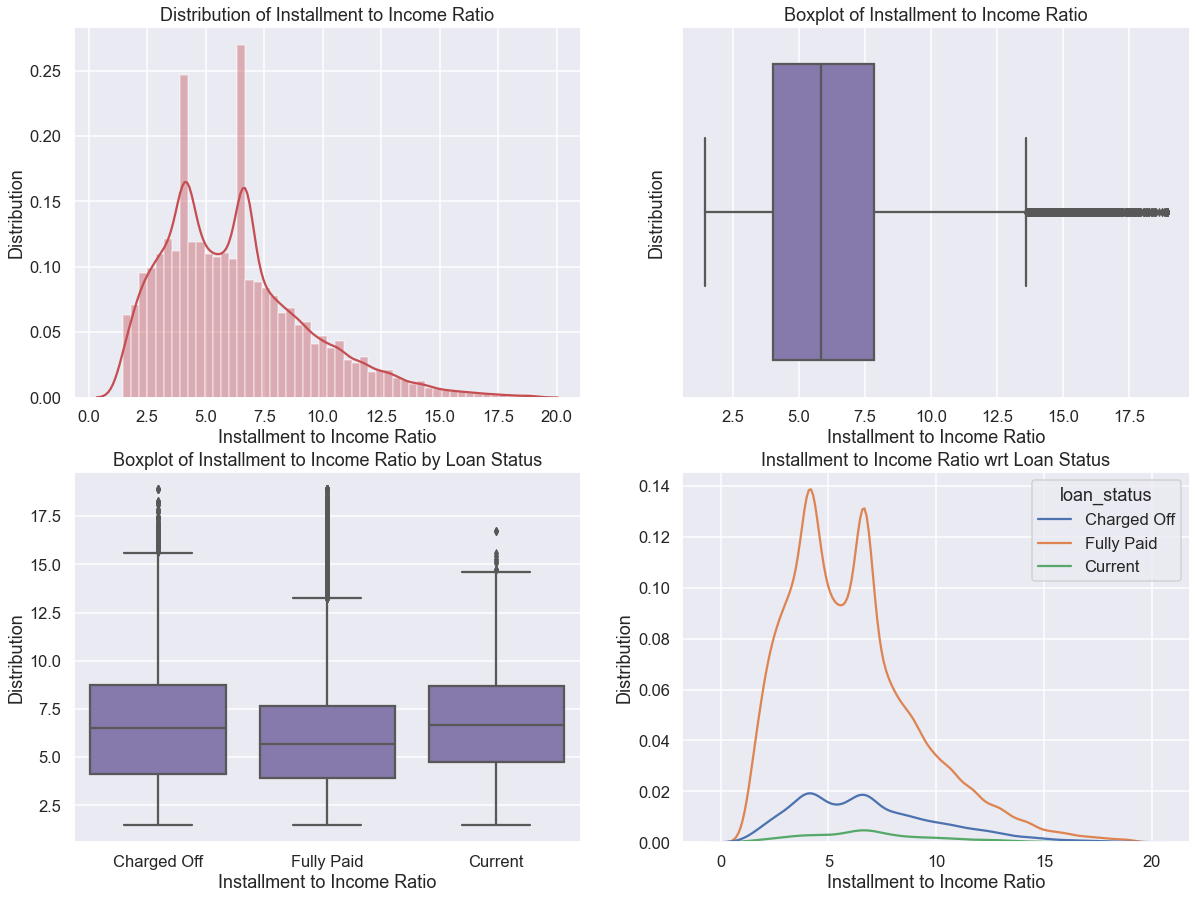

In [20]:
#Distribution of Installment to Income ratio
print(ft_data['installment_to_income'].describe())
print('\n')
print("IQR of Installment to Income Ratio {0}".format(IQR(ft_data['installment_to_income'])))
print('\n')
print(ft_data.groupby('loan_status').agg({'installment_to_income':['describe',IQR,ninetynine_Perc,Range,'skew']}))

plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title("Distribution of Installment to Income Ratio")
sns.distplot(ft_data['installment_to_income'],hist=True,kde=True,color='r')
plt.xlabel("Installment to Income Ratio")
plt.ylabel("Distribution")
plt.subplot(2,2,2)
plt.title("Boxplot of Installment to Income Ratio")
sns.boxplot(x='installment_to_income',data=ft_data,color='m')
plt.xlabel("Installment to Income Ratio")
plt.ylabel("Distribution")
plt.subplot(2,2,3)
plt.title("Boxplot of Installment to Income Ratio by Loan Status")
sns.boxplot(y='installment_to_income',x='loan_status',data=ft_data,color='m')
plt.xlabel("Installment to Income Ratio")
plt.ylabel("Distribution")
plt.subplot(2,2,4)
plt.title("Installment to Income Ratio wrt Loan Status")
sns.kdeplot(ft_data['installment_to_income'],hue=ft_data['loan_status'])
plt.xlabel('Installment to Income Ratio')
plt.ylabel("Distribution")
plt.show()

Data is right skewed

Average Installment to Income Ratio is 5.8 with variation of 3.83

We can see in comparison to fully paid borrowers, borrowers who were charged off have higher installment to income ratio which means, out of total income, major expenditure is made on the paying the installment , i.e installment was the larger chunk of their income. Also they had higher variation, which states that installment to income ratio of such borrowers are more likely to vary. We see that the first quartile and the third quartile is greater than fully paid which means these borrowers have larger installment amount which consume major percentage of their income 

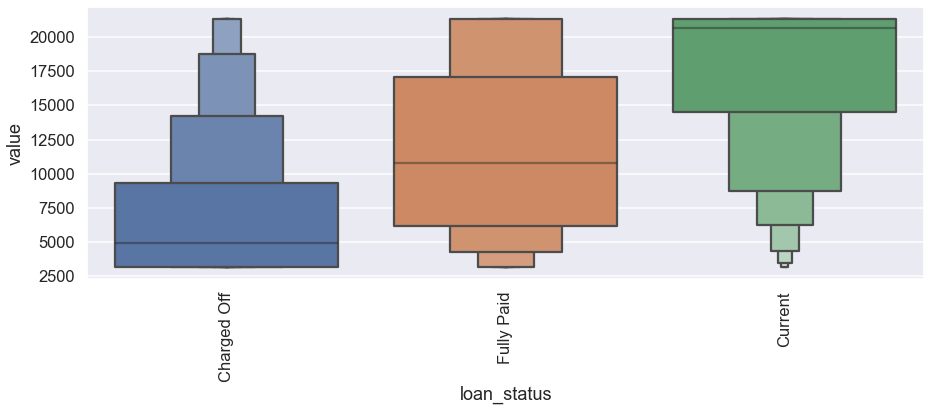

In [28]:
#Data Distribution - Total Payment 
#When we compare : Median total payment by applicants who have fully paid is higher than median total payment by the applicants which are being charged off
#Which supports that the applicants who belong to charged off have not made the complete payment. Minimum payment made by them and 25% of applicants have made the total payment of 3186 
#As we see from above these are the group of people who have applied for higher amount of loans but have not paid full payment
#If we notice the median of applicants who have fully paid is higher than the 75% of the total payment made by charged off applicants, 
#which is suggestive of : the distribution is different between the group, - Payment of fully paid customer will be on highers side significantly than the charged off customers
#The average payment made by the charged off customers is lesser than the payment made by the 25% of the customers who belong to fully paid group, which is
#Suggestive of that fully paid customers have availed loan significantly lesser than those who gets charged off
#This distribution will be similar to total payment inverse

plt.figure(figsize=(15,5))
sns.boxenplot(x="loan_status", y="value", data=pd.melt(ft_data,id_vars='loan_status',value_vars='total_pymnt'))
plt.xticks(rotation=90)
plt.show()


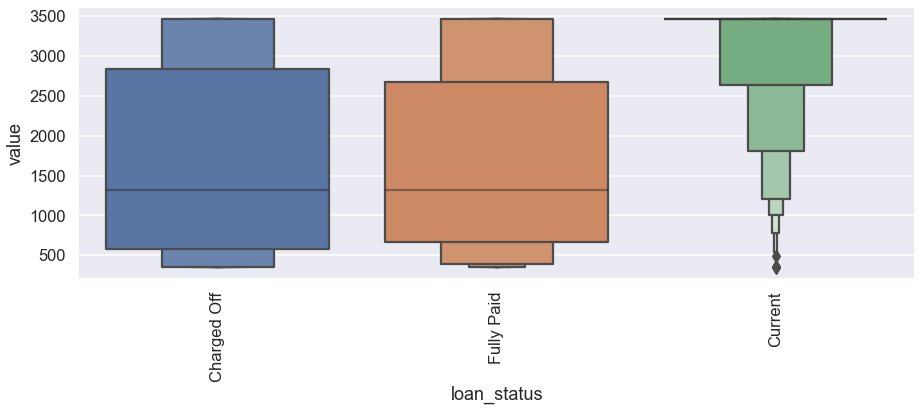

In [29]:
#Data Distribution - Total Received Interest 
#We can not see the significant difference in the distribution , it just tells that customer belonging to fully paid group tend to pay lesser interest , which is supported by fact that they take loan over lesser interest rate
plt.figure(figsize=(15,5))
sns.boxenplot(x="loan_status", y="value", data=pd.melt(ft_data,id_vars='loan_status',value_vars='total_rec_int'))
plt.xticks(rotation=90)
plt.show()


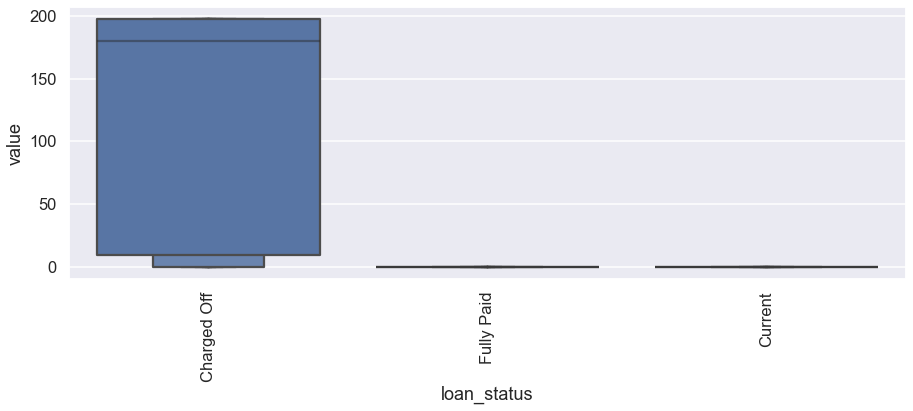

In [30]:
#Data Distribution - Recoveries 
#We can see the significant difference in the distribution , which states that recoveries are made of those who have been charged off
plt.figure(figsize=(15,5))
sns.boxenplot(x="loan_status", y="value", data=pd.melt(ft_data,id_vars='loan_status',value_vars='recoveries'))
plt.xticks(rotation=90)
plt.show()


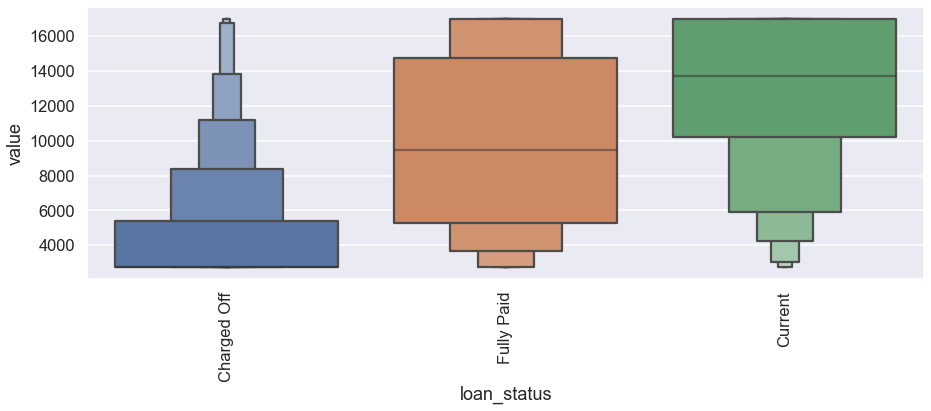

In [31]:
#Data Distribution - Total Principal Received 
#When we compare : Median total principal received by applicants who have fully paid is higher than median and 75% of the total principal received by the applicants which are being charged off
#Which is suggestive of the fact that the applicants who belong to charged off have not completely paid the principal amount of their loan. Minimum payment made by them and 25% of applicants have made the total payment of 2787 
#As we see from above these are the group of people who have applied for higher amount of loans but have not paid full payment, which means they have fall short on the principal amount , leaving the interest 
#If we notice the median of applicants who have fully paid is higher than the 75% of the total received principal by charged off applicants, 
#which is suggestive of : the distribution is different between the group, - principal paid by fully paid customer will be on highers side significantly than the charged off customers
#The average principal paid by the charged off customers is lesser than the principal paid by the 25% of the customers who belong to fully paid group, which is
#Suggestive of that fully paid customers have availed loan significantly lesser than those who gets charged off as they have paid principal amount 

plt.figure(figsize=(15,5))
sns.boxenplot(x="loan_status", y="value", data=pd.melt(ft_data,id_vars='loan_status',value_vars='total_rec_prncp'))
plt.xticks(rotation=90)
plt.show()


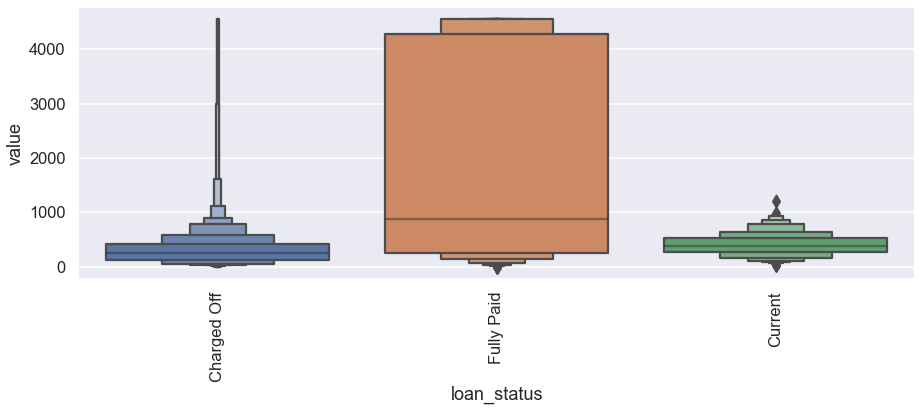

In [32]:
#Data Distribution - Last payment amount 
#When we compare : Median Last payment amount by applicants who have fully paid is higher than median and 75% of the Last Payment Amount by the applicants which are being charged off
#Which is suggestive of the fact that the applicants who belong to charged off pays very less amount in their last payment. 
#The variation in the last payment paid by those who belongs to charged off group is very less , they are very concentrated
#We can say those who pays more than 258 are less likely to default and above 411 probability of defaulting gets very very less.
plt.figure(figsize=(15,5))
sns.boxenplot(x="loan_status", y="value", data=pd.melt(ft_data,id_vars='loan_status',value_vars='last_pymnt_amnt'))
plt.xticks(rotation=90)
plt.show()


loan_status     Charged Off  Current  Fully Paid  Total  Charged Off Rate
home_ownership                                                           
OTHER                    18        0          80     98           18.3673
RENT                   2736      410       15344  18490           14.7972
OWN                     401       72        2370   2843           14.1048
MORTGAGE               2246      617       14351  17214           13.0475
NONE                      0        0           3      3            0.0000


loan_status  Charged Off     Current    Fully Paid         Total  \
count           5.000000    5.000000      5.000000      5.000000   
mean         1080.200000  219.800000   6429.600000   7729.600000   
std          1309.310582  279.469497   7751.033241   9321.488309   
min             0.000000    0.000000      3.000000      3.000000   
25%            18.000000    0.000000     80.000000     98.000000   
50%           401.000000   72.000000   2370.000000   2843.000000   
75% 

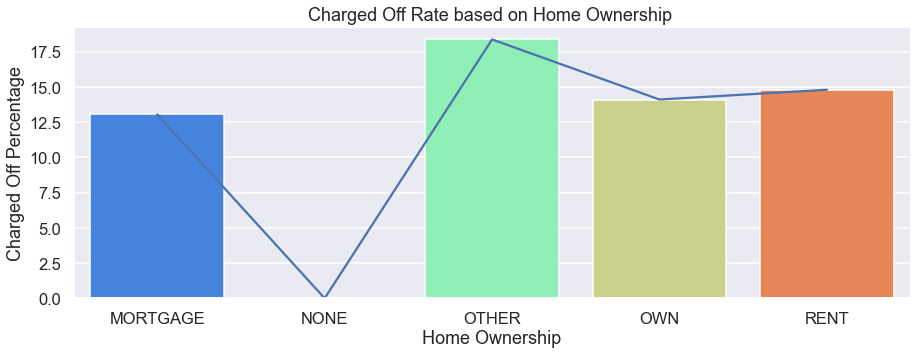

In [33]:
#Home ownership against charged off borrowers - Those who had charged off had maximum of Other category of Home Ownership
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'home_ownership',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Home Ownership ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Home Ownership")
plt.ylabel("Charged Off Percentage")
plt.show()

loan_status         Charged Off  Current  Fully Paid  Total  Charged Off Rate
purpose                                                                      
small_business              462       73        1247   1782           25.9259
renewable_energy             18        1          76     95           18.9474
educational                  52        0         263    315           16.5079
house                        59       14         295    368           16.0326
other                       597      120        3119   3836           15.5631
medical                     101       12         555    668           15.1198
moving                       84        7         468    559           15.0268
debt_consolidation         2680      568       14997  18245           14.6890
vacation                     50        4         298    352           14.2045
home_improvement            330       94        2456   2880           11.4583
car                         155       49        1294   1498     

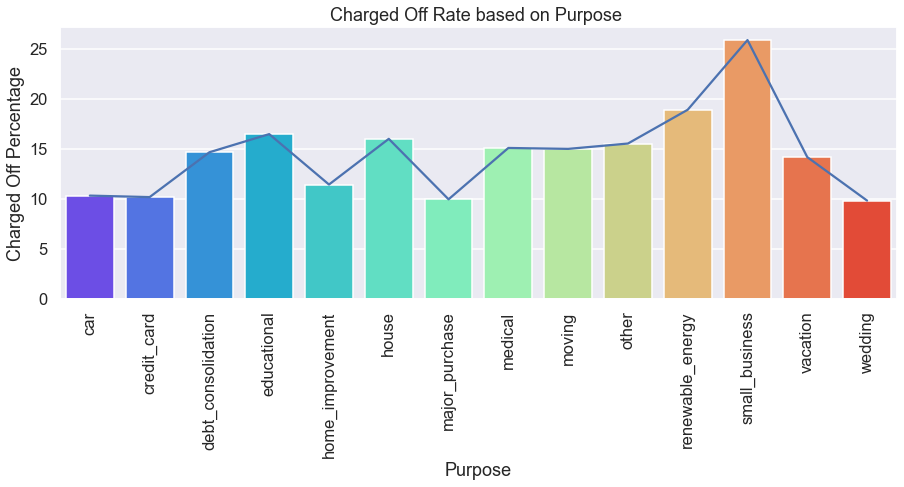

In [34]:
#Purpose against charged off borrowers
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'purpose',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Purpose ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Purpose")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

Top 3 purpose from which we have seen major charged off :

Small Busines - 25.9%

Renewable Energy - 18.9%

Educational - 16.5%

loan_status  Charged Off  Current  Fully Paid  Total  Charged Off Rate
addr_state                                                            
NE                     3        0           2      5           60.0000
NV                   101       18         363    482           20.9544
AK                    15        2          61     78           19.2308
SD                    11        2          50     63           17.4603
FL                   482       82        2212   2776           17.3631
ID                     1        0           5      6           16.6667
HI                    28        8         134    170           16.4706
MO                   106       15         540    661           16.0363
NM                    29        4         150    183           15.8470
OR                    69       16         352    437           15.7895
CA                  1075      143        5694   6912           15.5527
UT                    39        5         208    252           15.4762
GA    

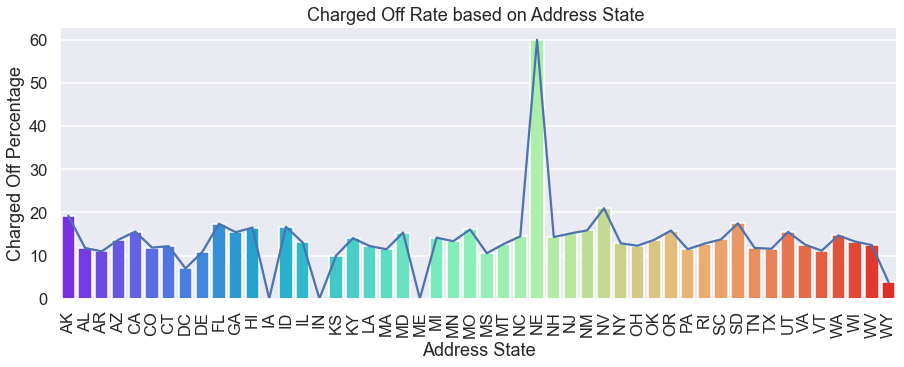

In [35]:
#Address State against charged off borrowers - Top charged off comes from Nebraska , atleast 60% 
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'addr_state',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Address State ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Address State")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status  Charged Off  Current  Fully Paid  Total  Charged Off Rate
delinq_2yrs                                                           
8                      1        0           1      2           50.0000
7                      1        0           3      4           25.0000
4                     13        2          46     61           21.3115
2                    124       14         529    667           18.5907
1                    488       93        2646   3227           15.1224
3                     31        8         175    214           14.4860
5                      3        0          18     21           14.2857
0                   4739      982       28719  34440           13.7602
6                      1        0           9     10           10.0000
9                      0        0           1      1            0.0000
11                     0        0           1      1            0.0000


loan_status  Charged Off     Current    Fully Paid         Total  \
count  

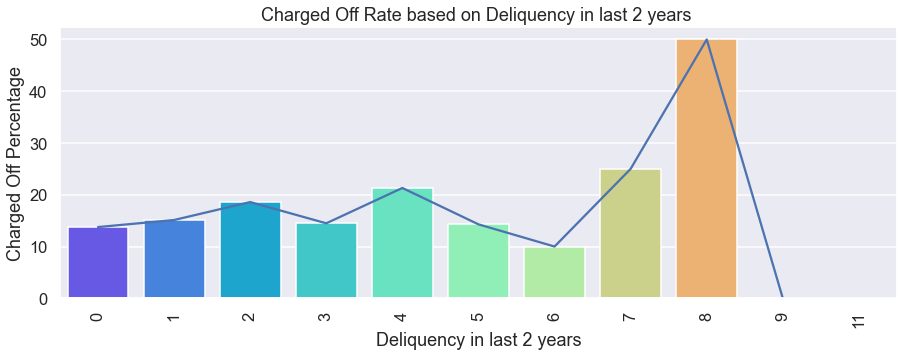

In [37]:
#Deliquency in last 2 years against charged off borrowers - Those who had 7-8 deliquecy in last two years are more likely to default
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'delinq_2yrs',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Deliquency in last 2 years ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Deliquency in last 2 years")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status     Charged Off  Current  Fully Paid  Total  Charged Off Rate
inq_last_6mths                                                           
7                         9        1          23     33           27.2727
6                        15        1          45     61           24.5902
3                       597       62        2316   2975           20.0672
8                         3        1          11     15           20.0000
5                        27        2         115    144           18.7500
2                       903      158        4602   5663           15.9456
1                      1623      298        8765  10686           15.1881
4                        45       10         257    312           14.4231
0                      2179      566       16014  18759           11.6158


loan_status  Charged Off     Current    Fully Paid         Total  \
count           9.000000    9.000000      9.000000      9.000000   
mean          600.111111  122.111111   3572.0000

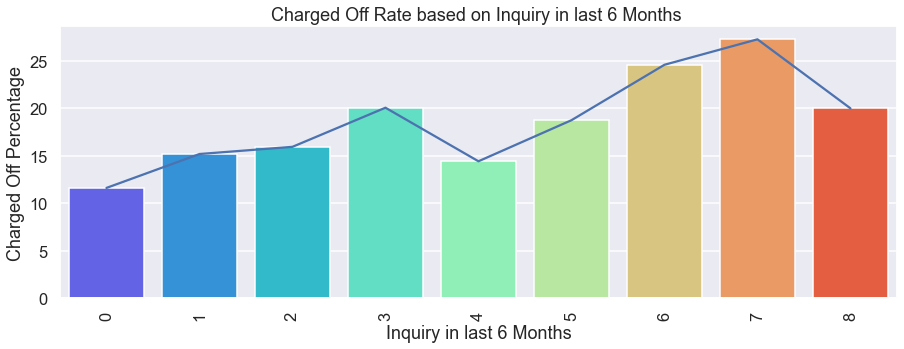

In [38]:
#Inquiry in Last 6 months against charged off borrowers - Those who had around 6 to 7 inquiries in last 6 months are more likely to default
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'inq_last_6mths',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Inquiry in last 6 Months ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Inquiry in last 6 Months")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status  Charged Off  Current  Fully Paid  Total  Charged Off Rate
grade                                                                 
G                    100       17         198    315           31.7460
F                    313       71         646   1030           30.3883
E                    700      175        1920   2795           25.0447
D                   1086      216        3893   5195           20.9047
C                   1288      257        6381   7926           16.2503
B                   1356      328       10005  11689           11.6007
A                    558       35        9105   9698            5.7538


loan_status  Charged Off     Current    Fully Paid         Total  \
count           7.000000    7.000000      7.000000      7.000000   
mean          771.571429  157.000000   4592.571429   5521.142857   
std           486.338653  118.971985   3986.949413   4398.568837   
min           100.000000   17.000000    198.000000    315.000000   
25%           435.5

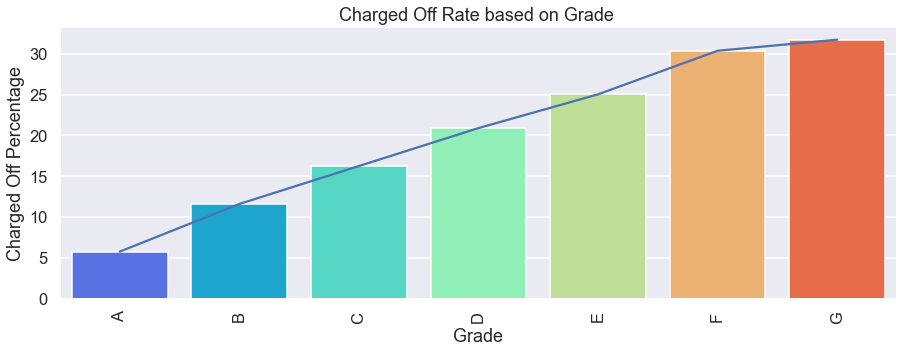

In [39]:
#Grade against charged off borrowers - As the grade increases the chances of charged off also increases
df =ft_data.pivot_table(values = 'funded_amnt',
                      index = 'grade',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Grade ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Grade")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status  Charged Off  Current  Fully Paid  Total  Charged Off Rate
sub_grade                                                             
F5                    53        5          57    115           46.0870
G3                    19        3          26     48           39.5833
G2                    28        1          49     78           35.8974
G5                    10        1          19     30           33.3333
F4                    53       16          95    164           32.3171
G1                    30       10          63    103           29.1262
F2                    68       16         160    244           27.8689
E4                   124       30         295    449           27.6169
F3                    50       10         122    182           27.4725
F1                    89       24         212    325           27.3846
E5                   106       29         275    410           25.8537
E1                   193       39         518    750           25.7333
E2    

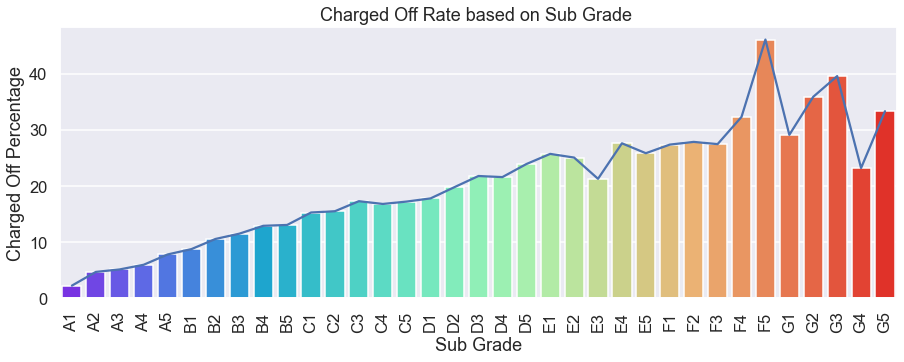

In [40]:
#Sub Grade against charged off borrowers - Major defaulters sub grades are : F5,G3,G5
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'sub_grade',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Sub Grade ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Sub Grade")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status           Charged Off  Current  Fully Paid  Total  \
funded_amt_range                                                
(15000.0, 18210.588]         1511      558        6521   8590   
(3823.519, 5500.0]           1308      101        8414   9823   
(9950.0, 15000.0]            1395      321        9005  10721   
(5500.0, 9950.0]             1187      119        8208   9514   

loan_status           Charged Off Rate  
funded_amt_range                        
(15000.0, 18210.588]           17.5902  
(3823.519, 5500.0]             13.3157  
(9950.0, 15000.0]              13.0118  
(5500.0, 9950.0]               12.4764  


loan_status  Charged Off     Current   Fully Paid         Total  \
count           4.000000    4.000000     4.000000      4.000000   
mean         1350.250000  274.750000  8037.000000   9662.000000   
std           136.965628  213.554638  1065.621884    879.107502   
min          1187.000000  101.000000  6521.000000   8590.000000   
25%          1277.750000  

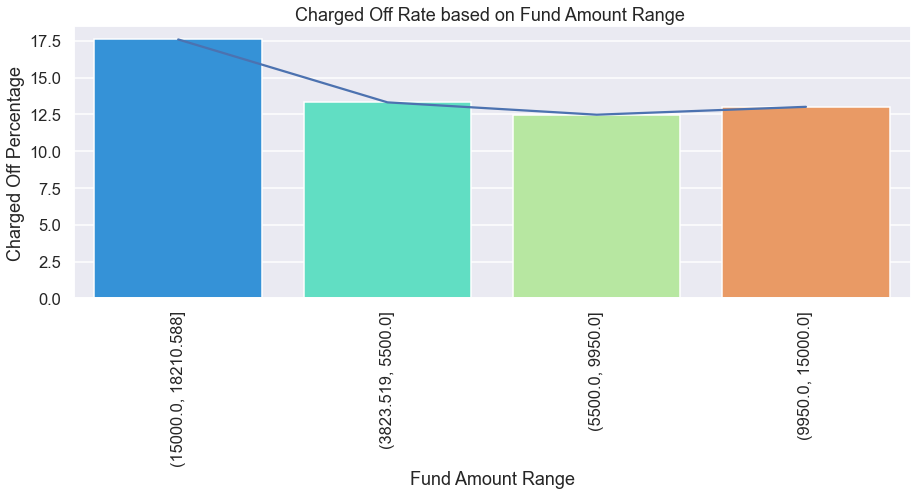

In [43]:
#Home ownership against charged off borrowers - Those who have received fund in range of 15000 to 18000+ have majorly defaulted
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'funded_amt_range',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Fund Amount Range ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Fund Amount Range")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status      Charged Off  Current  Fully Paid  Total  Charged Off Rate
int_rate_range                                                            
(19.08, 22.495]          448      170         801   1419           31.5715
(15.665, 19.08]         1233      322        3646   5201           23.7070
(12.25, 15.665]         1844      320        9038  11202           16.4613
(8.835, 12.25]          1413      263       10525  12201           11.5810
(5.403, 8.835]           463       24        8138   8625            5.3681


loan_status  Charged Off    Current    Fully Paid         Total  \
count           5.000000    5.00000      5.000000      5.000000   
mean         1080.200000  219.80000   6429.600000   7729.600000   
std           611.985866  125.66702   4059.687463   4446.071614   
min           448.000000   24.00000    801.000000   1419.000000   
25%           463.000000  170.00000   3646.000000   5201.000000   
50%          1233.000000  263.00000   8138.000000   8625.000000   
75% 

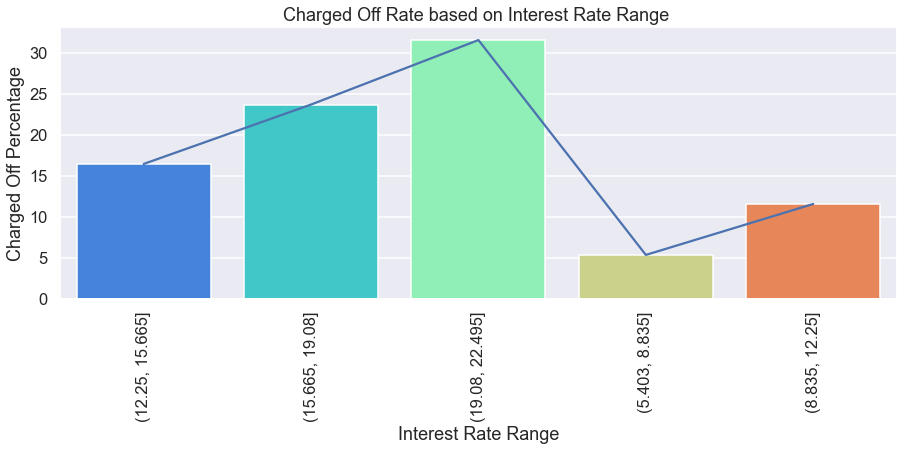

In [44]:
#Interest rate range against charged off borrowers

#As the interest rate increases probability of getting charged off also increases
df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'int_rate_range',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Interest Rate Range ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Interest Rate Range")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

loan_status             Charged Off  Current  Fully Paid  Total  \
annual_inc_range                                                  
(33914.262, 46467.99]          2075      249       10142  12466   
(46467.99, 58959.261]           931      199        5367   6497   
(58959.261, 71450.532]          852      170        4995   6017   
(71450.532, 83941.803]          505      138        3408   4051   
(83941.803, 96433.074]         1038      343        8236   9617   

loan_status             Charged Off Rate  
annual_inc_range                          
(33914.262, 46467.99]            16.6453  
(46467.99, 58959.261]            14.3297  
(58959.261, 71450.532]           14.1599  
(71450.532, 83941.803]           12.4661  
(83941.803, 96433.074]           10.7934  


loan_status  Charged Off     Current    Fully Paid         Total  \
count           5.000000    5.000000      5.000000      5.000000   
mean         1080.200000  219.800000   6429.600000   7729.600000   
std           590.88890

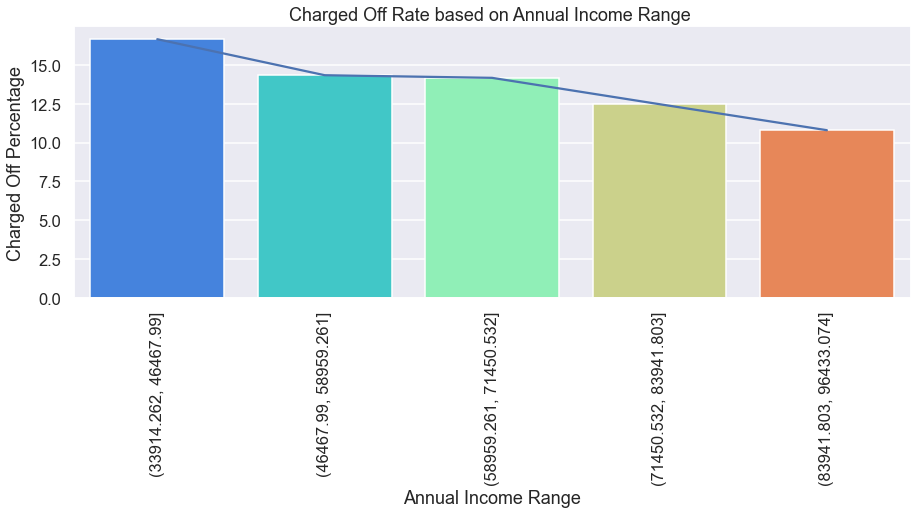

In [45]:
#Annual Income Range against charged off borrowers - Those whose annual income fall in the range of 33914 to 46467 are more likely to get charged of


df = ft_data.pivot_table(values = 'funded_amnt',
                      index = 'annual_inc_range',
                      columns = 'loan_status',
                      aggfunc = np.count_nonzero,
                      fill_value = 0,
                      margins = True,
                      margins_name = 'Total')
df['Charged Off Rate'] = 100*(round((df['Charged Off']/df['Total']), 6))
print(df.iloc[0:-1].sort_values(by = 'Charged Off Rate', ascending = False))
print('\n')
print(df.iloc[0:-1].describe())
print('\n')
X_data=df.iloc[0:-1].index
y_data=df.iloc[0:-1]['Charged Off Rate']
plt.figure(figsize=(15,5))
plt.title('Charged Off Rate based on Annual Income Range ')
sns.lineplot(data=y_data,estimator=np.median,palette='maroon')
sns.barplot(x=X_data,y=y_data,estimator=np.median,palette='rainbow')
plt.xlabel("Annual Income Range")
plt.ylabel("Charged Off Percentage")
plt.xticks(rotation=90)
plt.show()

In [21]:
ft_data.drop(['desc_isMissing','emp_title_isMissing','emp_length_isMissing'],axis=1,inplace=True)

In [22]:
ft_data.drop(['id','member_id'],axis=1,inplace=True)

In [23]:
#Correlation
charged_off_df = ft_data[ft_data.loan_status == 'Charged Off'].corr().drop(labels = {'out_prncp', 'out_prncp_inv'})

charged_off_df.dropna(axis = 1, how = 'all', inplace = True)

charged_off_df

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
loan_amnt                    1.000000     0.986498         0.901246  0.321044   
funded_amnt                  0.986498     1.000000         0.916847  0.329183   
funded_amnt_inv              0.901246     0.916847         1.000000  0.346373   
int_rate                     0.321044     0.329183         0.346373  1.000000   
installment                  0.939584     0.958135         0.856117  0.310960   
emp_length                   0.189013     0.193930         0.197405  0.041250   
annual_inc                   0.431078     0.425392         0.380231  0.164154   
dti                          0.082435     0.079588         0.092890  0.044918   
delinq_2yrs                 -0.035913    -0.033682        -0.037487  0.122294   
inq_last_6mths               0.000994     0.000058        -0.027117  0.057622   
open_acc                     0.205943     0.200573         0.177791  0.011057   
pub_rec                     -0.029306    -0.032735        -0.035467  0.080956   
revol_bal                    0.384425     0.373275         0.330488  0.111930   
revol_util                   0.051928     0.056112         0.075173  0.370587   
total_acc                    0.288068     0.278140         0.260837 -0.022213   
total_pymnt                  0.644349     0.654043         0.630408  0.254775   
total_pymnt_inv              0.610042     0.621304         0.679485  0.266284   
total_rec_prncp              0.505431     0.515106         0.485898  0.068264   
total_rec_int                0.731077     0.741015         0.722153  0.470850   
total_rec_late_fee          -0.044547    -0.044262        -0.056051  0.017124   
recoveries                   0.105121     0.112875         0.135124  0.160858   
collection_recovery_fee      0.224246     0.230140         0.234660  0.186462   
last_pymnt_amnt              0.427029     0.433332         0.373207  0.134316   
pub_rec_bankruptcies        -0.006846    -0.010109        -0.007254  0.080272   
application_to_funded_diff   0.318447     0.158899         0.126263  0.030032   
total_inst                   0.927552     0.938209         0.892878  0.469083   
balance                      0.705373     0.711684         0.671064  0.412360   
installment_to_income        0.615622     0.638903         0.572141  0.162213   

                            installment  emp_length  annual_inc       dti  \
loan_amnt                      0.939584    0.189013    0.431078  0.082435   
funded_amnt                    0.958135    0.193930    0.425392  0.079588   
funded_amnt_inv                0.856117    0.197405    0.380231  0.092890   
int_rate                       0.310960    0.041250    0.164154  0.044918   
installment                    1.000000    0.168349    0.431252  0.063744   
emp_length                     0.168349    1.000000    0.203665  0.056393   
annual_inc                     0.431252    0.203665    1.000000 -0.061978   
dti                            0.063744    0.056393   -0.061978  1.000000   
delinq_2yrs                   -0.019495    0.012276    0.031732 -0.070692   
inq_last_6mths                 0.008456    0.009659    0.069093 -0.028373   
open_acc                       0.192204    0.104142    0.301275  0.314406   
pub_rec                       -0.030226    0.061867    0.022618  0.004932   
revol_bal                      0.369449    0.178412    0.461761  0.320772   
revol_util                     0.078775    0.039139    0.092169  0.228314   
total_acc                      0.255167    0.181839    0.390317  0.275198   
total_pymnt                    0.636111    0.155822    0.335104  0.044339   
total_pymnt_inv                0.593885    0.161243    0.312604  0.051324   
total_rec_prncp                0.521733    0.124026    0.266550  0.008957   
total_rec_int                  0.669780    0.176307    0.327809  0.075871   
total_rec_late_fee            -0.032222   -0.042510    0.006213 -0.041083   
recoveries                     0.112686   -0.028316    0.0480

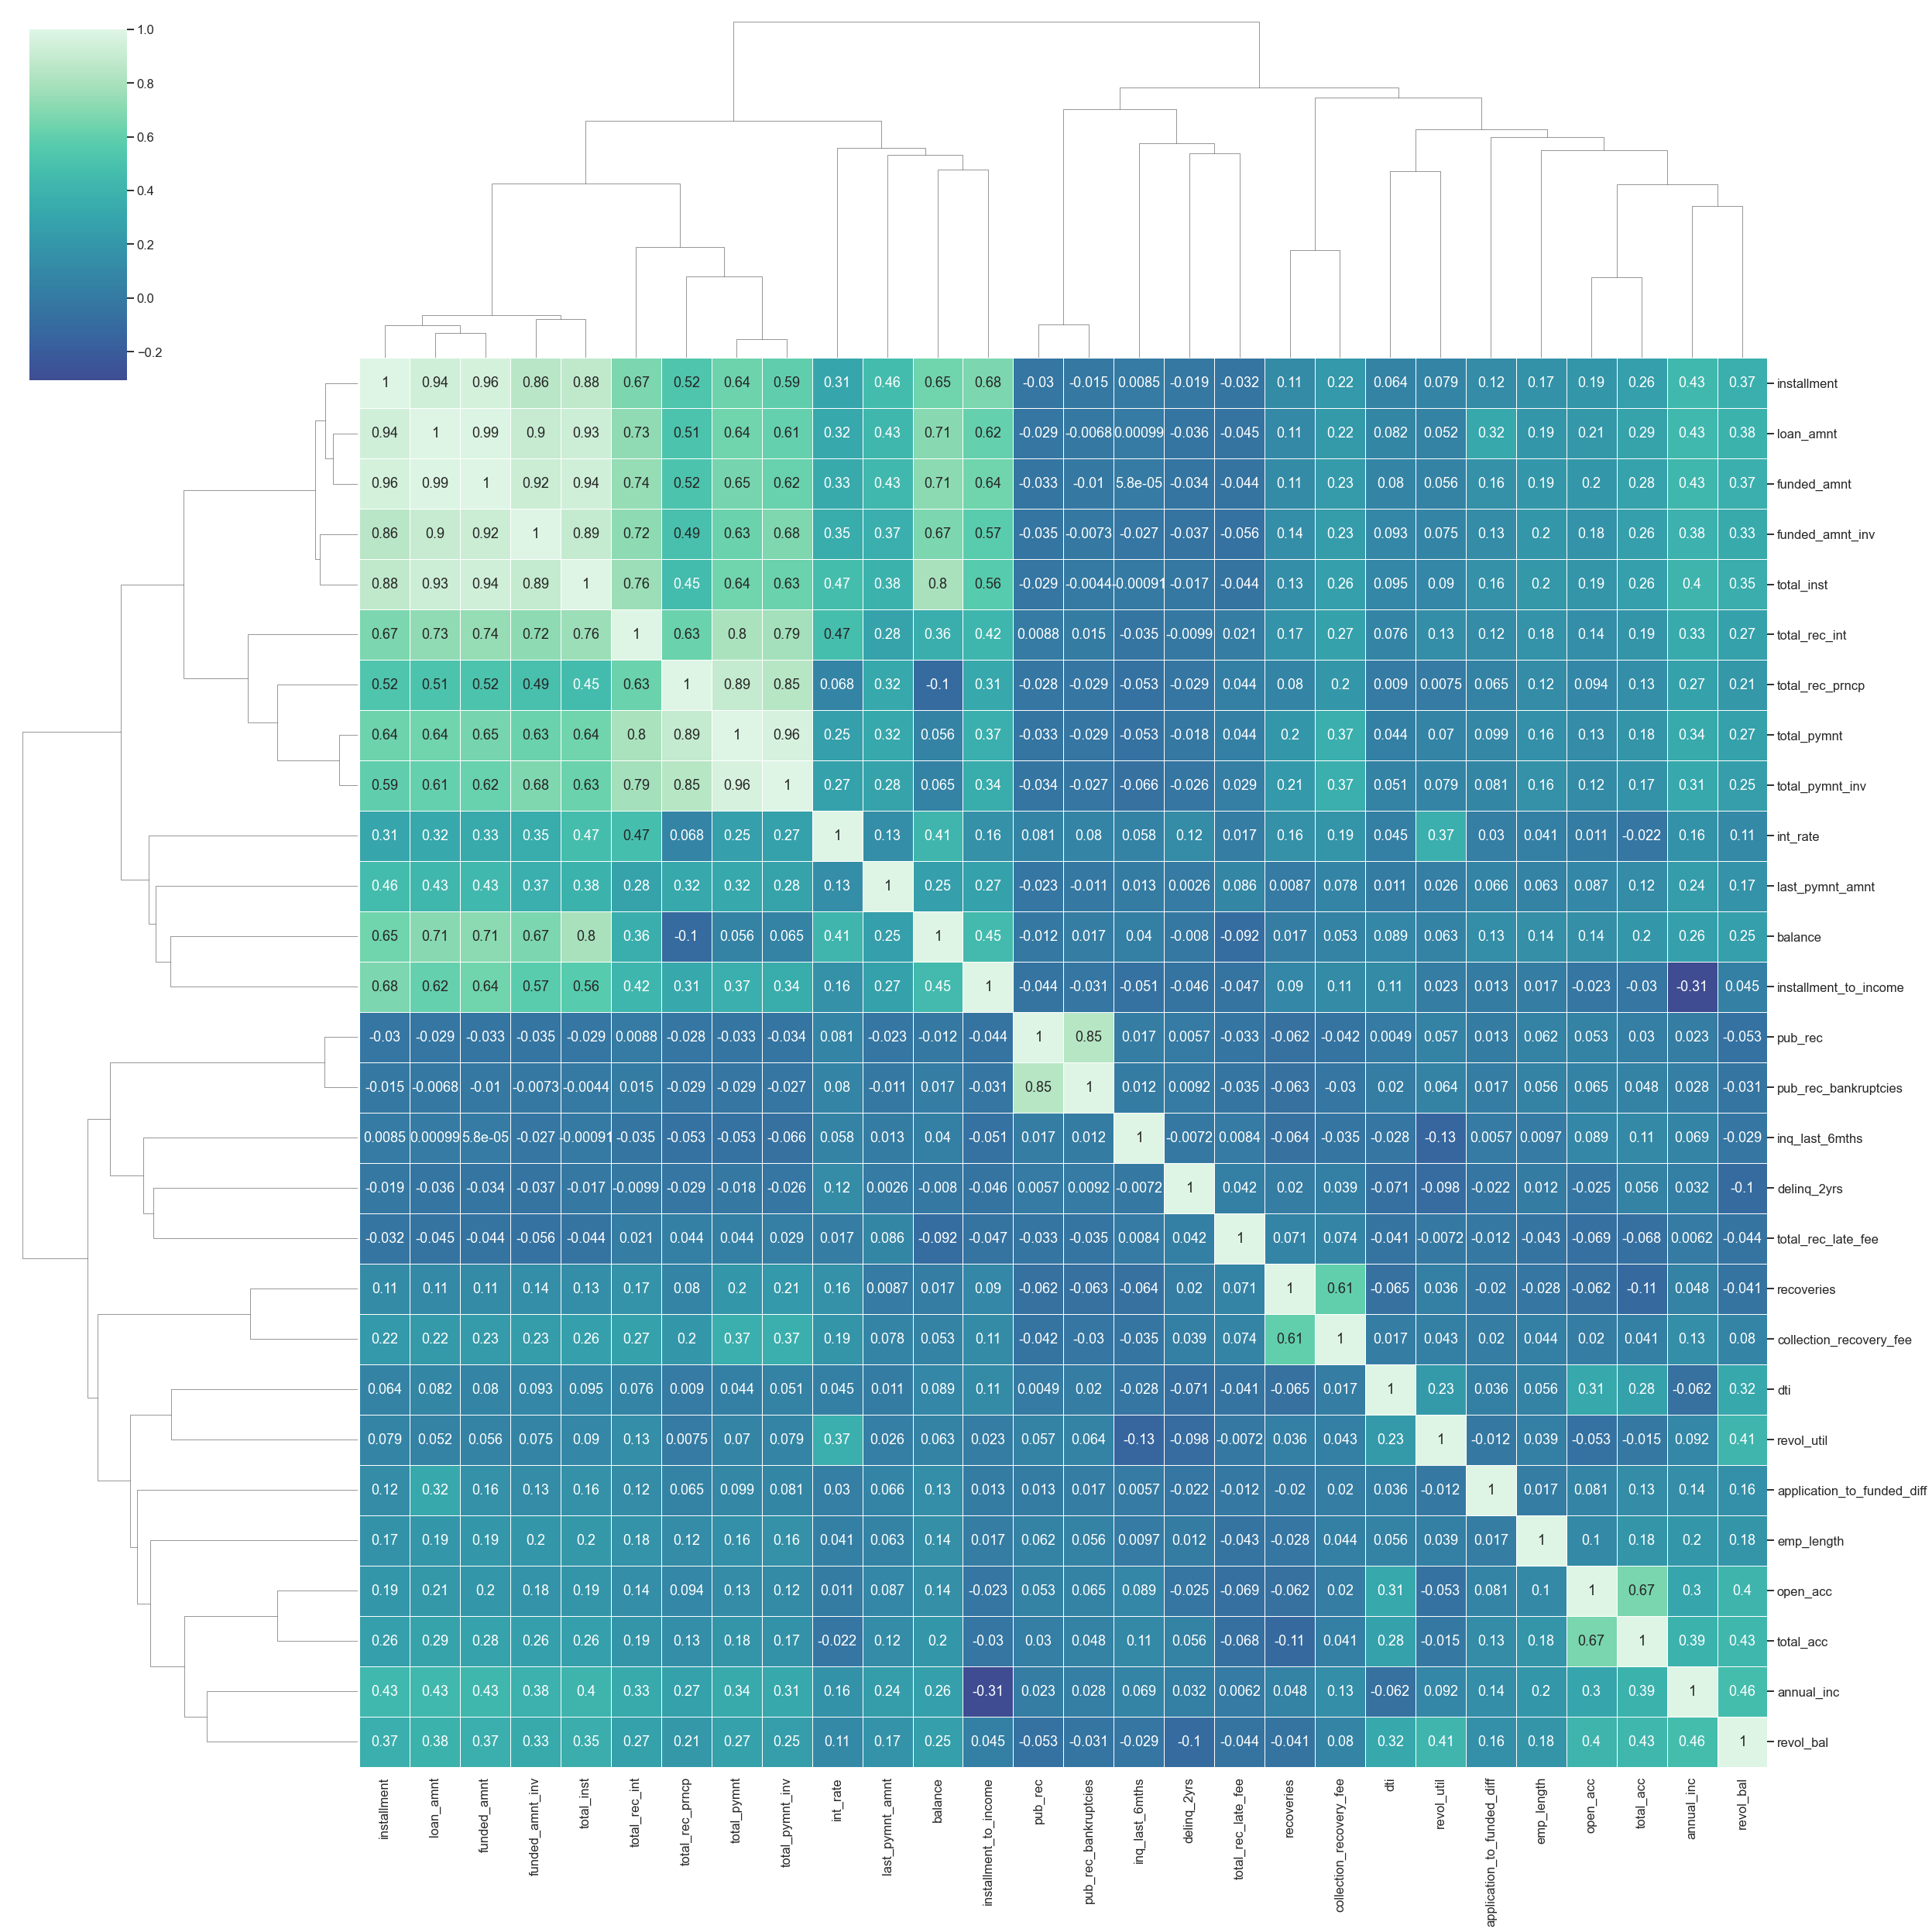

In [24]:
#Cluster Heatmap of correlation
sns.clustermap(charged_off_df, center = 0, cmap = 'mako', linewidths = 0.75, figsize = (35, 35), annot=True)
plt.show()

- We see that laon_amnt, funded_amnt and funded_amnt_inv forms one cluster, if there is increase or decrease in one , the others will increase or decrease. 

- We have a cluster of loan_amnt,funded_amnt,funded_amnt_inv,installment and total_inst, in which a change in one will affect the others substantially. This cluster is positively correlated with cluster of total_rec_int,total_rec_pymnt,total_rec_pymnt_inv and total_rec_prncp

- Hence bank should reduce the funding amount inorder to reduce the balance amount , i.e reducing the number of defaults

<Figure size 720x720 with 0 Axes>

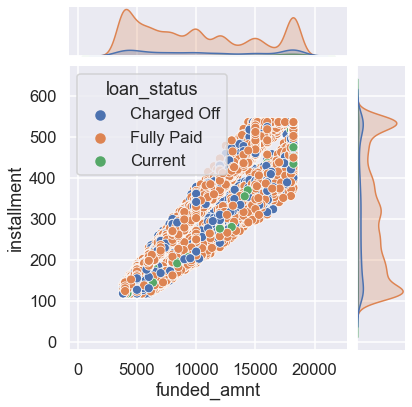

In [25]:
#Finding Relationship between funded amount and installment based on loan status
plt.figure(figsize=(10,10))
sns.jointplot(data=ft_data,x='funded_amnt',y='installment',hue='loan_status')
plt.show()

<Figure size 720x720 with 0 Axes>

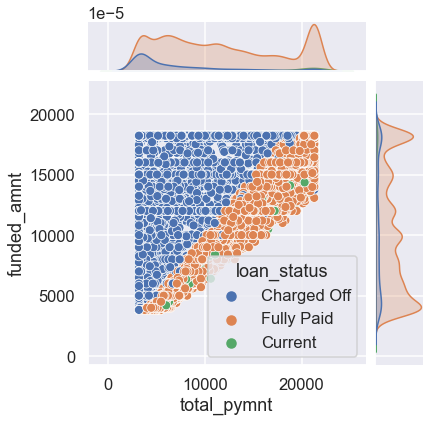

In [26]:
#Finding Relationship between Total Payment and installment based on loan status - we can see that funding amount for those who have been charged off are on higher side and can be clearly demarcated/seperated from those of fully paid
plt.figure(figsize=(10,10))
sns.jointplot(data=ft_data,x='total_pymnt',y='funded_amnt',hue='loan_status')
plt.show()

Text(0.5, 1.0, 'Loans issued by Region')

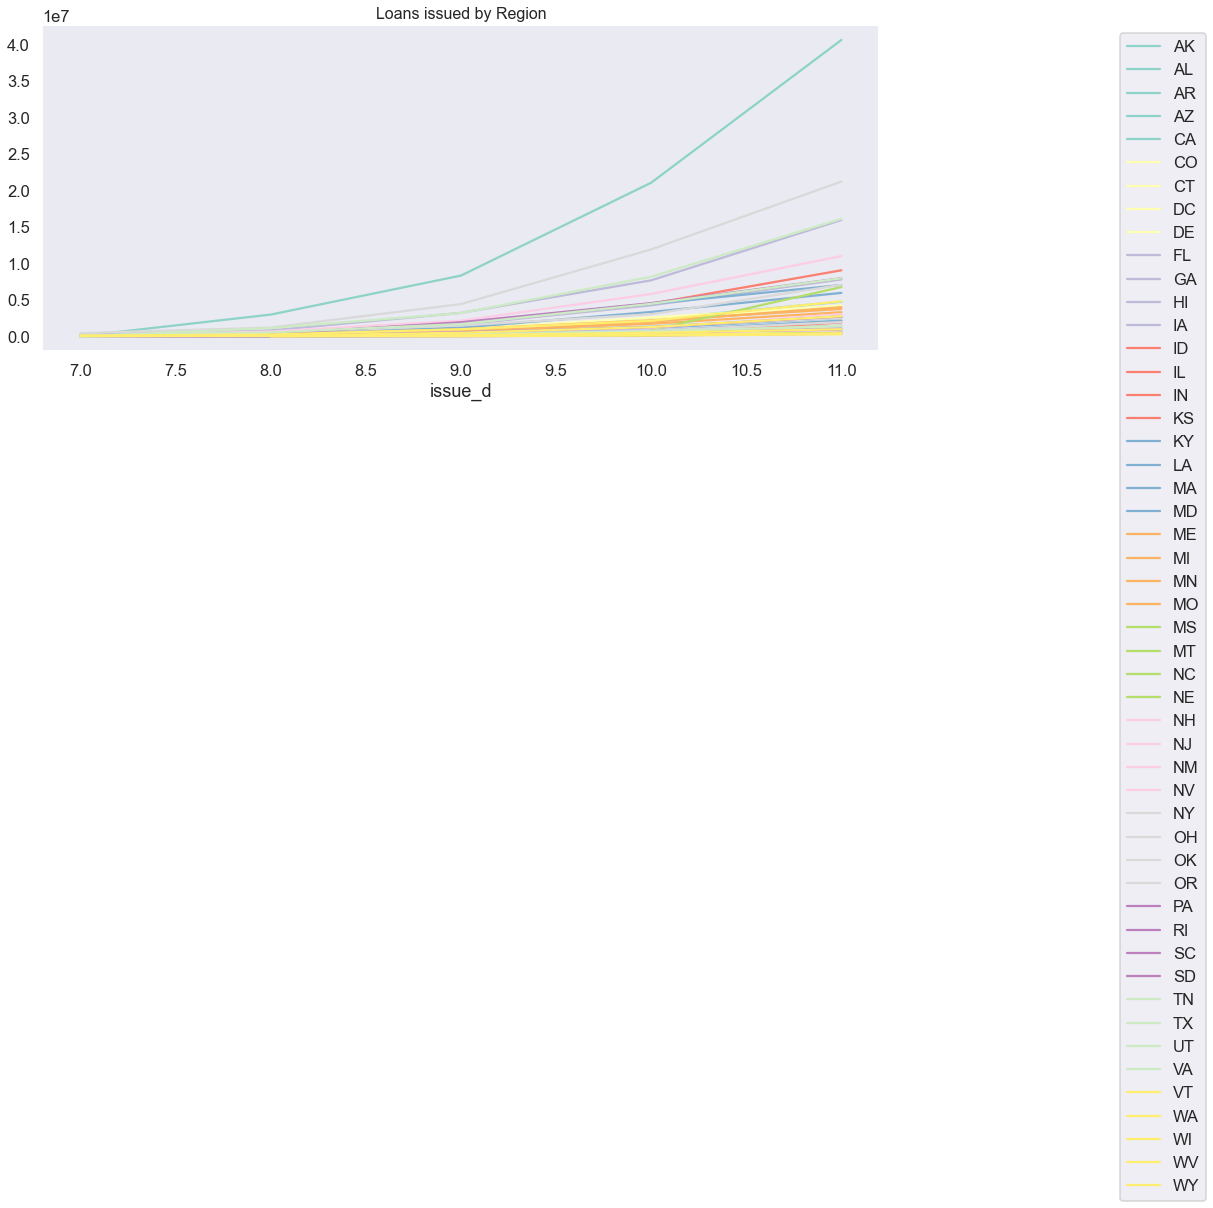

In [37]:
#Loan Issued to different states by issue year
#We see that over the period of time people in alaska have been tending to increase debt
cmap = plt.cm.Set3

by_issued_amount = ft_data.groupby(['issue_d', 'addr_state']).loan_amnt.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))
plt.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.title('Loans issued by Region', fontsize=16)